# Online Convex Optimisation Algorithms - Implementations

## 1 Preliminaries (Data Preparation)

In [1]:
mnist_train <- read.csv("./mnist_train.csv", stringsAsFactors = F, header = F)
mnist_test <- read.csv("./mnist_test.csv", stringsAsFactors = F, header = F)

names(mnist_test)[1] <- "label"
names(mnist_train)[1] <- "label"

# Convert label variable into factor

mnist_train$label <- factor(mnist_train$label)
summary(mnist_train$label)

mnist_test$label <- factor(mnist_test$label)
summary(mnist_test$label)

# Scaling data 

max(mnist_train[ ,2:ncol(mnist_train)]) # max pixel value is 255, lets use this to scale data


train <- cbind(label = 2*as.numeric(mnist_train[ ,1]==0)-1, mnist_train[ , 2:ncol(mnist_test)]/255,rep(1,length(mnist_train[ ,1])))
test <- cbind(label = 2*as.numeric(mnist_test[ ,1]==0)-1, mnist_test[ , 2:ncol(mnist_test)]/255,rep(1,length(mnist_train[ ,1])))

0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949

0    1    2    3    4    5    6    7    8    9 
 980 1135 1032 1010  982  892  958 1028  974 1009

[1] 255

### Helper functions

In [2]:
# Cost function: regularized hinge loss
library(RColorBrewer)



hingereg <- function(x, a, b,lambda){
  threshold <- (a %*% x) * b
  cost <- 1- (a  %*% x) * b
  cost[threshold >= 1] <- 0
  return(mean(cost)+lambda*sum(x^2)/2) # standardized dividing by n
}

# The corresponding gradient
# Matrix containing all the gradients, O(n*d) (n gradients of size d)
# a is a matrix of all pixels, b is the vector containing all labels

gradreg <- function(x, a, b,lambda) {
  threshold <- b * (a %*% x) # define hard-margin SVM
  gradient <- - b* a # matrice qui contient tous les gradients
  gradient[threshold >= 1] <- 0
  return(colMeans(gradient)+lambda*x) # standardized dividing by n
}

# The instatenuous gradient
# Gradient vector (a vector, b is one label)

instgradreg <- function(x, a, b,lambda) {
  threshold <- b * (a %*% x) # define hard-margin SVM
  gradient <- - b* a
  gradient[threshold >= 1] <- 0
  return(gradient+lambda*x)
}  



# projection for a vector v with non-negative coordinates on the simplex of radius z

pisimplex <- function(v,z=1){
  n <- length(v)
  u <- sort(v, TRUE)
  
  su <- cumsum(u)  
  rho <- max(which(u > (su-z) / (1:n)))  # d_0
  
  theta <- (su[rho] -z) / rho
  
  w <- pmax(v - theta, 0)
  return(w) 
}

pib1 <- function(x,z=1){
  v <- abs(x)
  if (sum(v)>z){
    u <- pisimplex(v,z)
    x<-sign(x)*u   # we calculated u for |x| so we must multiply by the sign
  }
  return(x)
}

pib1w <- function(x,w,z=1){
  if (sum(abs(x))>z & z != Inf){
    v <- abs(x* w)
  u <- order(-v)
  sx <- cumsum(abs(x)[u])
  sw <- cumsum(1/w[u])
    rho <- max(which(v[u] > (sx-z) / sw))
  theta <- (sx[rho] -z) / sw[rho]
    x<-sign(x)*pmax(abs(x) - theta/w, 0)}

  return(x)
}

rate <- function(param,c){colMeans(c[,1]*( as.matrix(c[,-1]) %*% t(as.matrix(param[, 2:(ncol(param) - 1)])))>0)}

## 2 Gradient Descent

In [3]:
# GD algorithm

GDproj <- function(a, b, init,iters=100, cost,  grad, lambda=1, z=Inf) {
  
  param <- data.frame(matrix(nrow = 101, ncol = length(init) + 1))
  colnames(param) <- c(colnames(a), "Loss")
  x<-c( init)
  param[1, ] <- c(x, cost( init, a, b,lambda))
  j<-2
  
  
  for (i in 1:iters) {
    eta <-  1 /(lambda*i)
    x <- pib1(x - eta * grad(x, as.matrix(a), b, lambda),z)
    param[i + 1, ]  <- c(x,cost(x, a, b,lambda))
  }
  
  
  param <- cbind(Iteration = 1:nrow(param), param)
  
  return(param)
  }

In [4]:
# 10 GD parametrisations

start_time <- Sys.time()
paramGD1 <- GDproj(a = as.matrix(train[,-1]),
                  b = train[,1],
                  init = rep(0, dim(train[-1])[2]),
                  iters = 100,  # =1000 Play with the number of iterations
                  cost = hingereg,
                  grad = gradreg,
                  lambda = 1e-3) # Play with the regularization parameter (default = 1/3)
end_time <- Sys.time()
end_time - start_time


start_time <- Sys.time()
paramGD2 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 1e-2) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD3 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 1e-1) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD4 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 1/3) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD5 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 0.5) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD6 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 2/3) 
end_time <- Sys.time()
end_time - start_time


start_time <- Sys.time()
paramGD7 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 1) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD8 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 2) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD9 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 5) 
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGD10 <- GDproj(a = as.matrix(train[,-1]),
                   b = train[,1],
                   init = rep(0, dim(train[-1])[2]),
                   iters = 100,  
                   cost = hingereg,
                   grad = gradreg,
                   lambda = 10) 
end_time <- Sys.time()
end_time - start_time


Time difference of 45.96674 secs

Time difference of 49.53223 secs

Time difference of 50.16358 secs

Time difference of 48.91644 secs

Time difference of 52.34136 secs

Time difference of 50.08049 secs

Time difference of 57.15681 secs

Time difference of 54.60952 secs

Time difference of 1.051458 mins

Time difference of 59.94716 secs

In [5]:
rateGD1 <- rate(paramGD1,test)
rateGD2 <- rate(paramGD2,test)
rateGD3 <- rate(paramGD3,test)
rateGD4 <- rate(paramGD4,test)
rateGD5 <- rate(paramGD5,test)

rateGD6 <- rate(paramGD6,test)
rateGD7 <- rate(paramGD7,test)
rateGD8 <- rate(paramGD8,test)
rateGD9 <- rate(paramGD9,test)
rateGD10 <- rate(paramGD10,test)

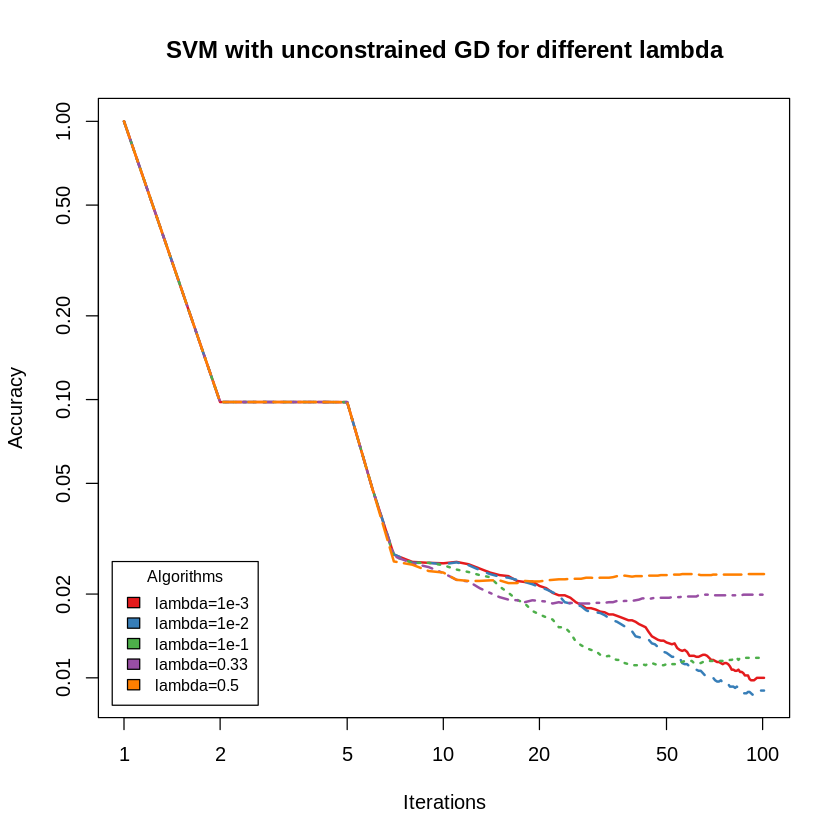

In [6]:
# Plot
matplot(paramGD1[,1],cbind(1-rateGD1, 1-rateGD2, 1-rateGD3, 1-rateGD4, 1-rateGD5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with unconstrained GD for different lambda",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("lambda=1e-3", "lambda=1e-2", "lambda=1e-1", "lambda=0.33", "lambda=0.5"), fill=brewer.pal(5,"Set1"), cex=0.8)

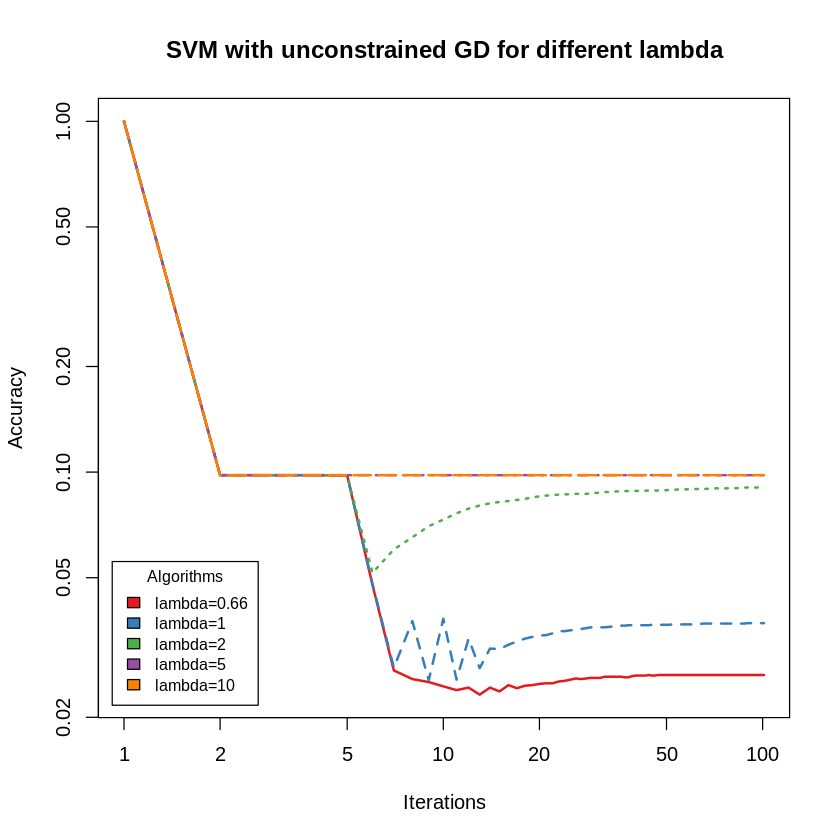

In [7]:
matplot(paramGD6[,1],cbind(1-rateGD6, 1-rateGD7, 1-rateGD8, 1-rateGD9, 1-rateGD10),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with unconstrained GD for different lambda",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("lambda=0.66", "lambda=1", "lambda=2", "lambda=5", "lambda=10"), fill=brewer.pal(5,"Set1"), cex=0.8)

### Projected GD

In [8]:
start_time <- Sys.time()
paramGDproj1 <- GDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 100,  # =1000 Play with the number of iterations
                     cost = hingereg,
                     grad = gradreg,
                     lambda = 0.1,  #default 1/3
                     z = 0.01) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj2 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 0.1) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj3 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 0.5) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj4 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 1) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj5 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 5) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()

start_time <- Sys.time()
paramGDproj6 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 10) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj7 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 20) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj8 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 50) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj9 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 100) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramGDproj10 <- GDproj(a = as.matrix(train[,-1]),
                       b = train[,1],
                       init = rep(0, dim(train[-1])[2]),
                       iters = 100,  # =1000 Play with the number of iterations
                       cost = hingereg,
                       grad = gradreg,
                       lambda = 0.1,  #default 1/3
                       z = 1000) # Play with the regularization parameter
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()

Time difference of 44.15996 secs

Time difference of 37.43453 secs

Time difference of 48.7182 secs

Time difference of 44.69474 secs

Time difference of 55.10892 secs

Time difference of 54.74292 secs

Time difference of 54.56884 secs

Time difference of 48.24251 secs

Time difference of 48.68074 secs

Time difference of 1.012533 mins

In [9]:
rateGDproj1 <- rate(paramGDproj1,test)
rateGDproj2 <- rate(paramGDproj2,test)
rateGDproj3 <- rate(paramGDproj3,test)
rateGDproj4 <- rate(paramGDproj4,test)
rateGDproj5 <- rate(paramGDproj5,test)

rateGDproj6 <- rate(paramGDproj6,test)
rateGDproj7 <- rate(paramGDproj7,test)
rateGDproj8 <- rate(paramGDproj8,test)
rateGDproj9 <- rate(paramGDproj9,test)
rateGDproj10 <- rate(paramGDproj10,test)

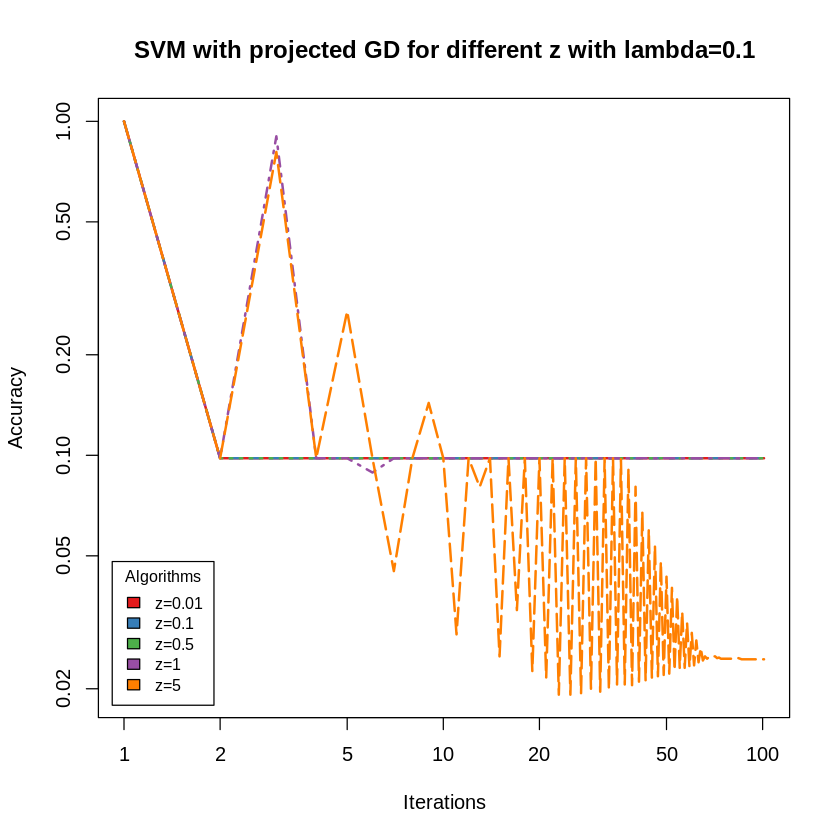

In [10]:
matplot(paramGDproj1[,1],cbind(1-rateGDproj1, 1-rateGDproj2, 1-rateGDproj3, 1-rateGDproj4, 1-rateGDproj5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected GD for different z with lambda=0.1",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z=0.01", "z=0.1", "z=0.5", "z=1", "z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

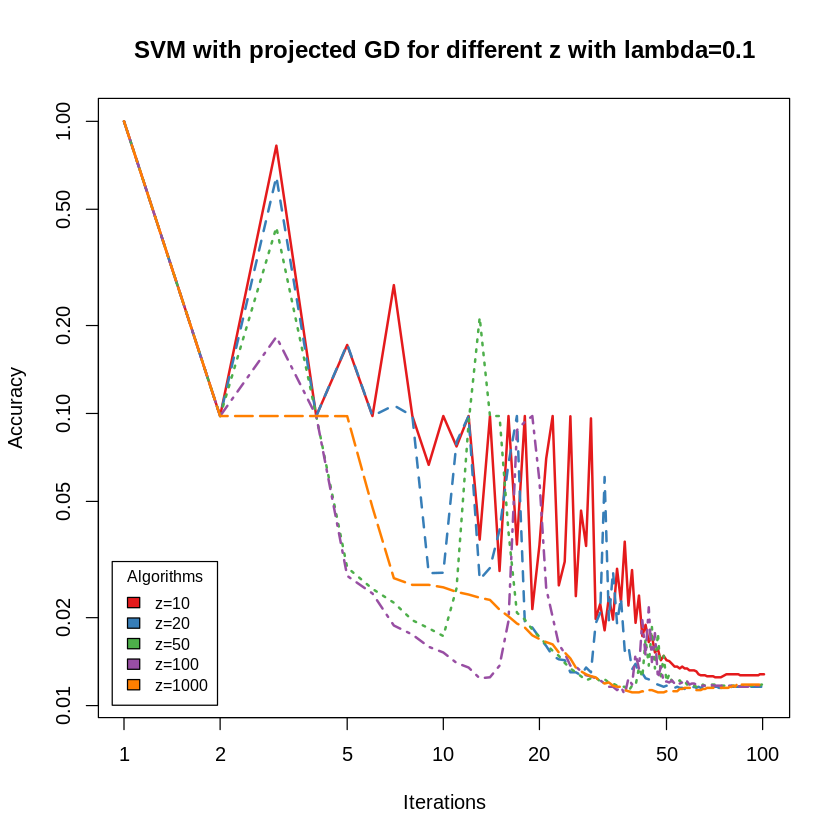

In [11]:
matplot(paramGDproj6[,1],cbind(1-rateGDproj6, 1-rateGDproj7, 1-rateGDproj8, 1-rateGDproj9, 1-rateGDproj10),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected GD for different z with lambda=0.1",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z=10", "z=20", "z=50", "z=100", "z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

## 3 Stochastic Gradient Descent

In [12]:
# SGD algorithm

SGDproj <- function(a, b, init, iters = length(b), cost,  instgrad, lambda,z=Inf) {
  
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  
  param <- data.frame(matrix(nrow = 101, ncol = length(init) + 1))
  colnames(param) <- c(colnames(a), "Loss")
  x <- c( init)
  m <- x
  param[1, ] <- c(m, cost( init, a, b,lambda))
  j <- 2
  
  for (i in 1:iters) {
    eta <-  1/(lambda*i) # 1/sqrt(i) play with the learning rate
    x <- pib1(x - eta * instgrad(x,a[i,], b[i],lambda),z)
    m <- ((i-1)*m + x)/i
    if (i%% (iters/100) == 0)
    {
      param[j, ] <- c(m,cost(m, a, b,lambda))
      j<-j+1}
  }
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

In [13]:
start_time <- Sys.time()
set.seed(100)
paramSGD1 <- SGDproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda =1e-3) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD2 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 1e-2) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD3 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 100000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 1e-1) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD4 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 1/3) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD5 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 0.5) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD6 <- SGDproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 2/3) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD7 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 1) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD8 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 100000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 2) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD9 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 5) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGD10 <- SGDproj(a = as.matrix(train[,-1]),
                     b = train[,1],
                     init = rep(0, dim(train[-1])[2]),
                     iters = 10000,  # =1000 Play with the number of iterations (avec 10.000 on n'utilisera jamais tout le train sample qui contient 60.000)
                     cost = hingereg,
                     instgrad = instgradreg,
                     lambda = 10) # Play with the regularization parameter
end_time <- Sys.time()
print(end_time - start_time)


start_time <- Sys.time()
set.seed(100)
paramSGDproj1 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 0.01) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj2 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 0.1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj3 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 0.5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj4 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj5 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

paramSGDproj6 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 10) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj7 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 20) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj8 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 50) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj9 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSGDproj10 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 2.737448 secs
Time difference of 2.415237 secs
Time difference of 19.49822 secs
Time difference of 2.108139 secs
Time difference of 2.214581 secs
Time difference of 2.35701 secs
Time difference of 2.283244 secs
Time difference of 20.14335 secs
Time difference of 2.317302 secs
Time difference of 2.29884 secs
Time difference of 3.675024 secs
Time difference of 3.478675 secs
Time difference of 3.463013 secs
Time difference of 3.543631 secs
Time difference of 2.74775 secs
Time difference of 5.111953 secs
Time difference of 2.536767 secs
Time difference of 2.558513 secs
Time difference of 2.264726 secs
Time difference of 2.161004 secs


In [14]:
rateSGD1 <- rate(paramSGD1,test)
rateSGD2 <- rate(paramSGD2,test)
rateSGD3 <- rate(paramSGD3,test)
rateSGD4 <- rate(paramSGD4,test)
rateSGD5 <- rate(paramSGD5,test)
rateSGD6 <- rate(paramSGD6,test)
rateSGD7 <- rate(paramSGD7,test)
rateSGD8 <- rate(paramSGD8,test)
rateSGD9 <- rate(paramSGD9,test)
rateSGD10 <- rate(paramSGD10,test)

rateSGDproj1 <- rate(paramSGDproj1,test)
rateSGDproj2 <- rate(paramSGDproj2,test)
rateSGDproj3 <- rate(paramSGDproj3,test)
rateSGDproj4 <- rate(paramSGDproj4,test)
rateSGDproj5 <- rate(paramSGDproj5,test)
rateSGDproj6 <- rate(paramSGDproj6,test)
rateSGDproj7 <- rate(paramSGDproj7,test)
rateSGDproj8 <- rate(paramSGDproj8,test)
rateSGDproj9 <- rate(paramSGDproj9,test)
rateSGDproj10 <- rate(paramSGDproj10,test)

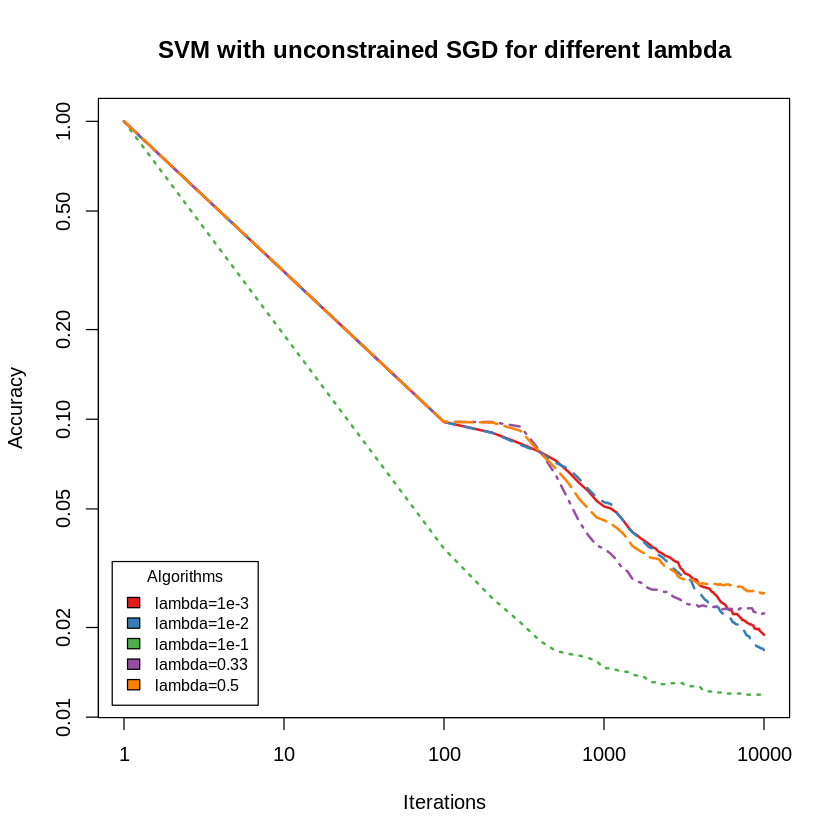

In [15]:
matplot(paramSGD1[,1],cbind(1-rateSGD1, 1-rateSGD2, 1-rateSGD3, 1-rateSGD4, 1-rateSGD5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with unconstrained SGD for different lambda",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("lambda=1e-3", "lambda=1e-2", "lambda=1e-1", "lambda=0.33", "lambda=0.5"), fill=brewer.pal(5,"Set1"), cex=0.8)

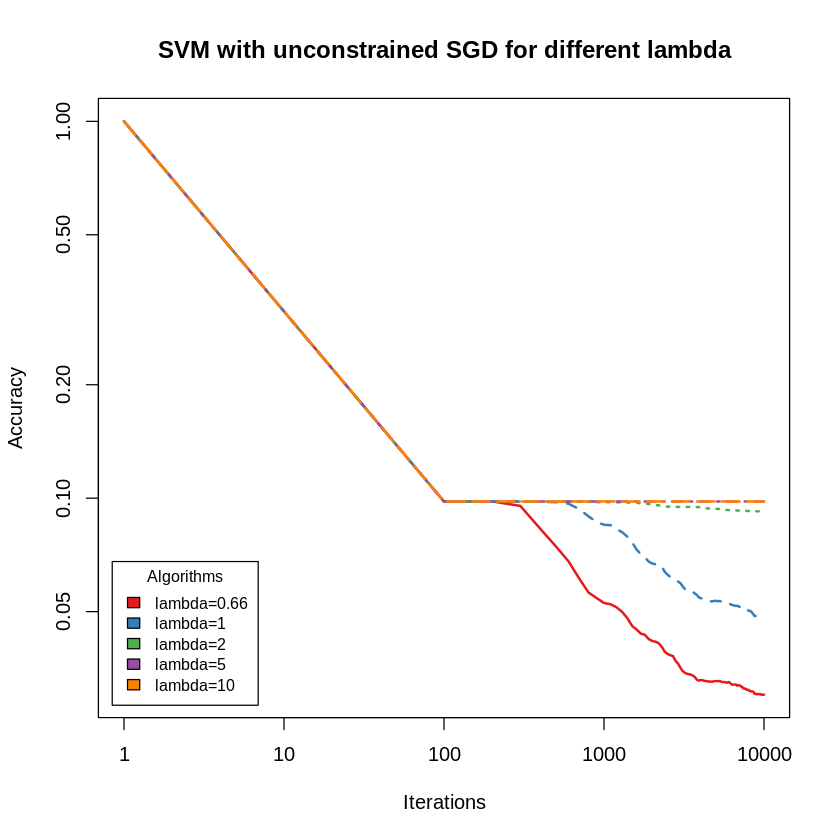

In [16]:
matplot(paramSGD6[,1],cbind(1-rateSGD6, 1-rateSGD7, 1-rateSGD8, 1-rateSGD9, 1-rateSGD10),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with unconstrained SGD for different lambda",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("lambda=0.66", "lambda=1", "lambda=2", "lambda=5", "lambda=10"), fill=brewer.pal(5,"Set1"), cex=0.8)

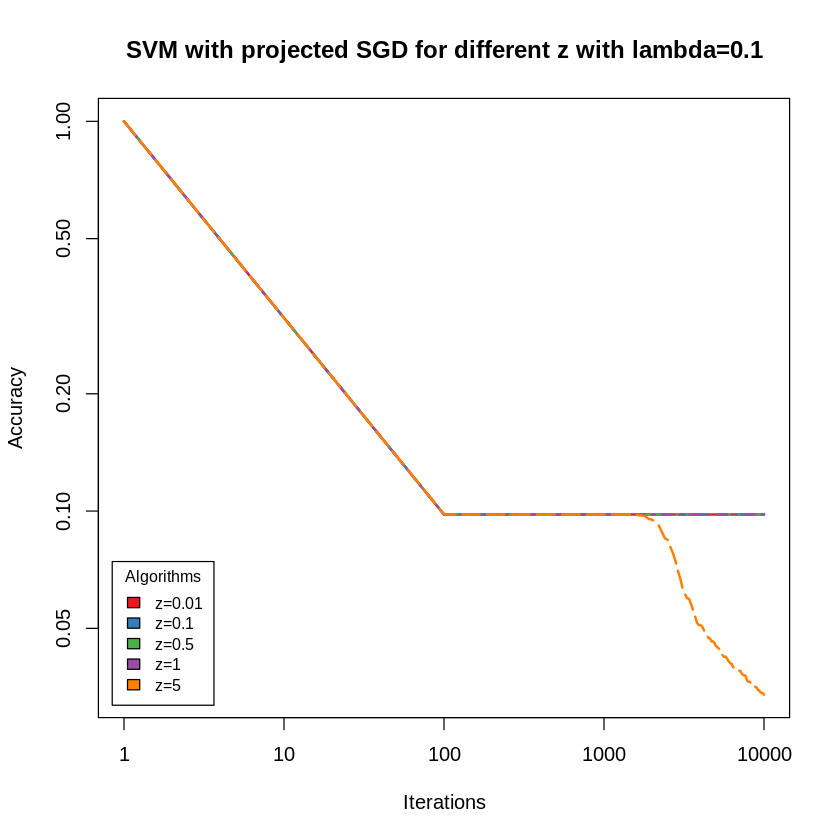

In [17]:
matplot(paramSGDproj1[,1],cbind(1-rateSGDproj1, 1-rateSGDproj2, 1-rateSGDproj3, 1-rateSGDproj4, 1-rateSGDproj5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SGD for different z with lambda=0.1",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z=0.01", "z=0.1", "z=0.5", "z=1", "z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

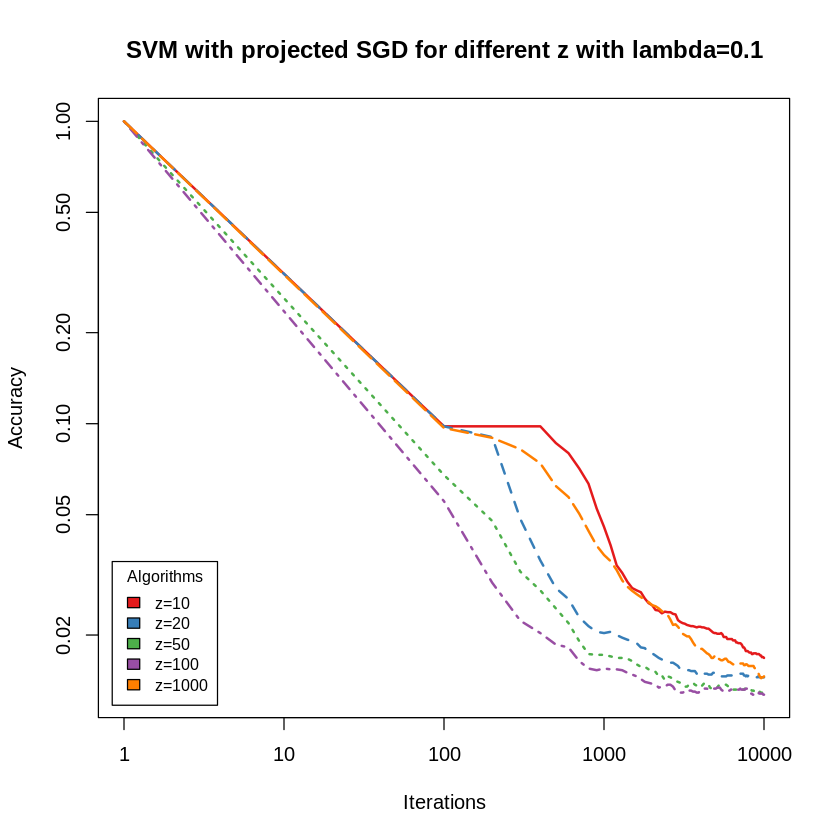

In [18]:
matplot(paramSGDproj6[,1],cbind(1-rateSGDproj6, 1-rateSGDproj7, 1-rateSGDproj8, 1-rateSGDproj9, 1-rateSGDproj10),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SGD for different z with lambda=0.1",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z=10", "z=20", "z=50", "z=100", "z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

## 4 Regularised Follow The Leader

### Stochatic Mirror Descent

In [19]:
SMDproj <- function(a, b, init, iters = length(b), cost,  instgrad, lambda,z =Inf) {
  
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  d<-ncol(a)
  
  
  param <- data.frame(matrix(nrow = 101, ncol = length(init) + 1))
  colnames(param) <- c(colnames(a), "Loss")
  x <- c(init)
  m <- x
  param[1, ] <- c(m, cost( m, a, b,lambda))
  theta <- x
  j <- 2
  
  for (i in 1:iters) {    
    eta <- sqrt(1/i)  # 1/i play with the learning rate
    theta <- theta - eta * instgrad(x, a[i,], b[i], lambda)
    x <- pib1(theta,z)
    m <- ((i-1)*m + x)/i
    if (i%% (iters/100) == 0)  
    {
      param[j, ] <- c(m,cost(m, a, b,lambda))
      j<-j+1}
  }
  
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

In [20]:
start_time <- Sys.time()
set.seed(100)
paramSMDproj1 <- SMDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z=1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj2 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=2) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj3 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=3) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj4 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=4) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj5 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)


start_time <- Sys.time()
set.seed(100)
paramSMDproj6 <- SMDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z=10) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj7 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=20) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj8 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=50) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj9 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSMDproj10 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

start_time <- Sys.time()
set.seed(100)
paramSMDproj11 <- SMDproj(a = as.matrix(train[,-1]),
                         b = train[,1],
                         init = rep(0, dim(train[-1])[2]),
                         iters = 10000,  # =1000 Play with the number of iterations
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=30) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSGDproj1 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 30) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)


Time difference of 3.21884 secs
Time difference of 3.476393 secs
Time difference of 3.284373 secs
Time difference of 3.57229 secs
Time difference of 3.680736 secs
Time difference of 3.930541 secs
Time difference of 3.761821 secs
Time difference of 3.794546 secs
Time difference of 4.047356 secs
Time difference of 2.243044 secs
Time difference of 3.639825 secs
Time difference of 2.159671 secs


In [21]:
rateSMDproj1 <- rate(paramSMDproj1,test)
rateSMDproj2 <- rate(paramSMDproj2,test)
rateSMDproj3 <- rate(paramSMDproj3,test)
rateSMDproj4 <- rate(paramSMDproj4,test)
rateSMDproj5 <- rate(paramSMDproj5,test)
rateSMDproj6 <- rate(paramSMDproj6,test)
rateSMDproj7 <- rate(paramSMDproj7,test)
rateSMDproj8 <- rate(paramSMDproj8,test)
rateSMDproj9 <- rate(paramSMDproj9,test)
rateSMDproj10 <- rate(paramSMDproj10,test)
rateSMDproj11 <- rate(paramSMDproj11,test)

rateSGDproj1 <- rate(paramSGDproj1,test)

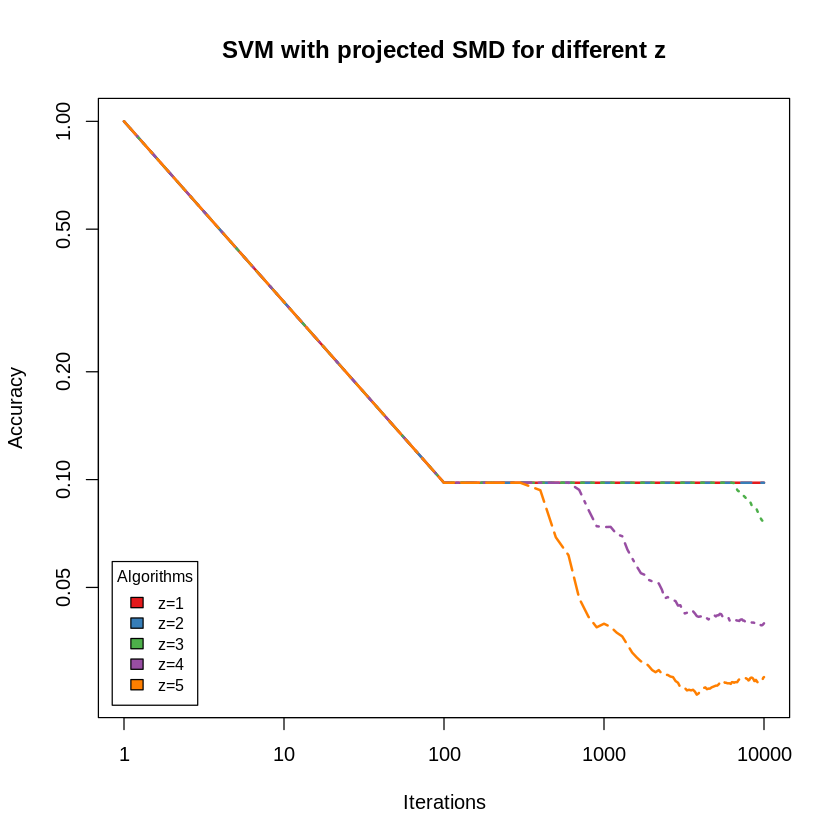

In [22]:
matplot(paramSMDproj1[,1],cbind(1-rateSMDproj1, 1-rateSMDproj2, 1-rateSMDproj3, 1-rateSMDproj4, 1-rateSMDproj5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SMD for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z=1", "z=2", "z=3", "z=4", "z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

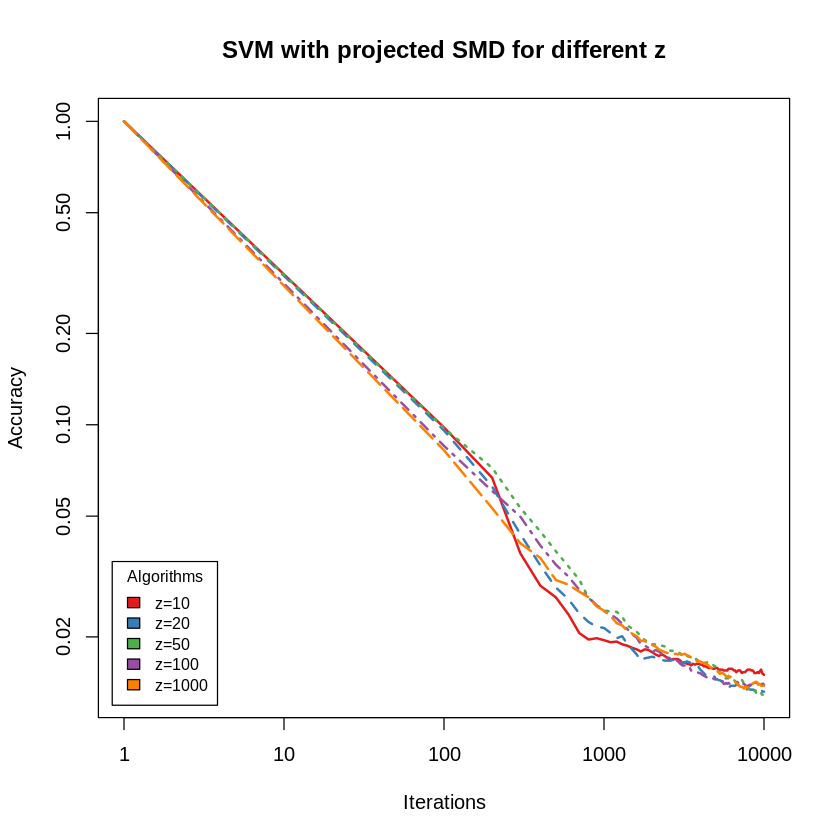

In [23]:
matplot(paramSMDproj6[,1],cbind(1-rateSMDproj6, 1-rateSMDproj7, 1-rateSMDproj8, 1-rateSMDproj9, 1-rateSMDproj10),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SMD for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z=10", "z=20", "z=50", "z=100", "z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

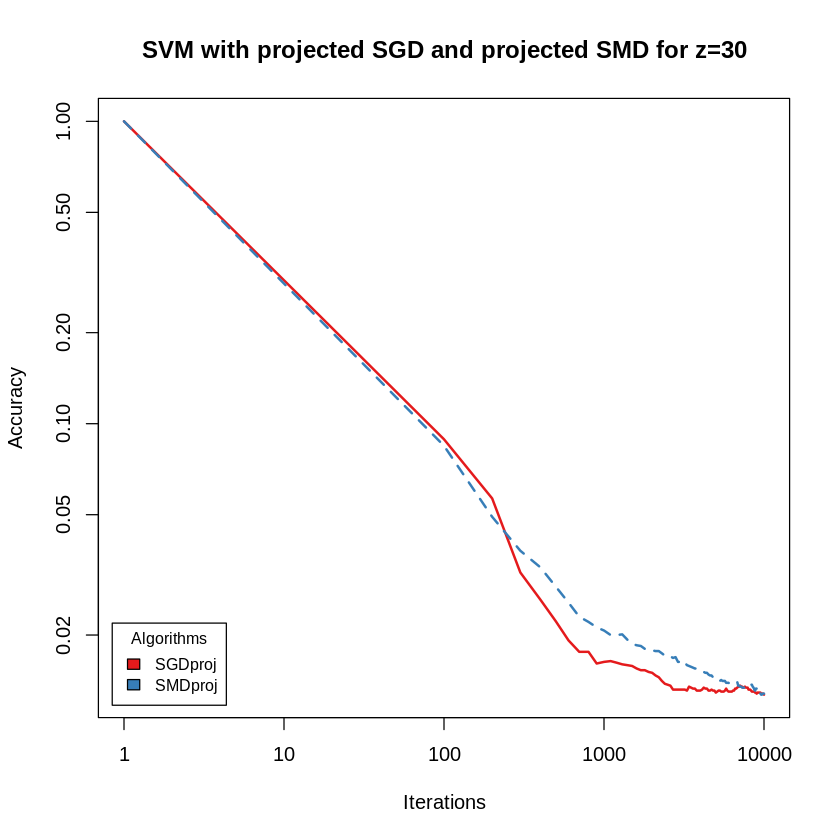

In [24]:
matplot(paramSGDproj1[,1],cbind(1-rateSGDproj1, 1-rateSMDproj11) ,type="l",col=brewer.pal(2,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SGD and projected SMD for z=30",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("SGDproj","SMDproj"), fill=brewer.pal(2,"Set1"), cex=0.8)

### Exponentiated Gradient +/-

In [25]:
SEGpm <- function(a, b, iters = length(b), cost,  instgrad, lambda,z) {
  
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  d<-ncol(a)
    
  param <- data.frame(matrix(nrow = 101, ncol = d + 1))
  colnames(param) <- c(colnames(a), "Loss")
  w <- rep(1,2*d)
  w <- w/sum(w)
  x <- z*c(w[1:d]-w[d+1:d])
  m = x
  param[1, ] <- c(m, cost(m, a, b,lambda))
  j<-2
  
  for (i in 1:iters) {
    eta <- sqrt(1/i) #   play with the learning rate
    instg <- instgrad( x, a[i,], b[i], lambda)
    w <- exp( eta * c(-instg,instg))*w
    w <- w/sum(w)
    x <- z*c(w[1:d]-w[d+1:d])
    m <- ((i-1)*m + x)/i
    if (i%% (iters/100) == 0)
    {
      param[j, ] <- c(m,cost(m, a, b,lambda))
      j<-j+1}
  }
  
  param <- cbind(Iteration = c(1, 1:100*(iters/100)) , param)
  
  return(param)
  
}

In [26]:
start_time <- Sys.time()
set.seed(100)
paramSEGpm1 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=0.01) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm2 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=0.1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm3 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=0.5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm4 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm5 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm6 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=10) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm7 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=20) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm8 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=50) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm9 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramSEGpm10 <- SEGpm(a = as.matrix(train[,-1]),
                    b = train[,1],
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)

paramSGDproj2 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 8.01854 secs

Time difference of 4.325484 secs

Time difference of 5.236665 secs

Time difference of 4.055931 secs

Time difference of 3.413373 secs

Time difference of 4.273277 secs

Time difference of 3.318527 secs

Time difference of 3.285987 secs

Time difference of 3.416106 secs

Time difference of 3.105548 secs

Time difference of 2.699764 secs


In [27]:
rateSEGpm1 <- rate(paramSEGpm1,test)
rateSEGpm2 <- rate(paramSEGpm2,test)
rateSEGpm3 <- rate(paramSEGpm3,test)
rateSEGpm4 <- rate(paramSEGpm4,test)
rateSEGpm5 <- rate(paramSEGpm5,test)
rateSEGpm6 <- rate(paramSEGpm6,test)
rateSEGpm7 <- rate(paramSEGpm7,test)
rateSEGpm8 <- rate(paramSEGpm8,test)
rateSEGpm9 <- rate(paramSEGpm9,test)
rateSEGpm10 <- rate(paramSEGpm10,test)

rateSGDproj2 <- rate(paramSGDproj2,test)

In [28]:
rateSEGpm9 <- rate(paramSEGpm9,test)
rateSGDproj2 <- rate(paramSGDproj2,test)

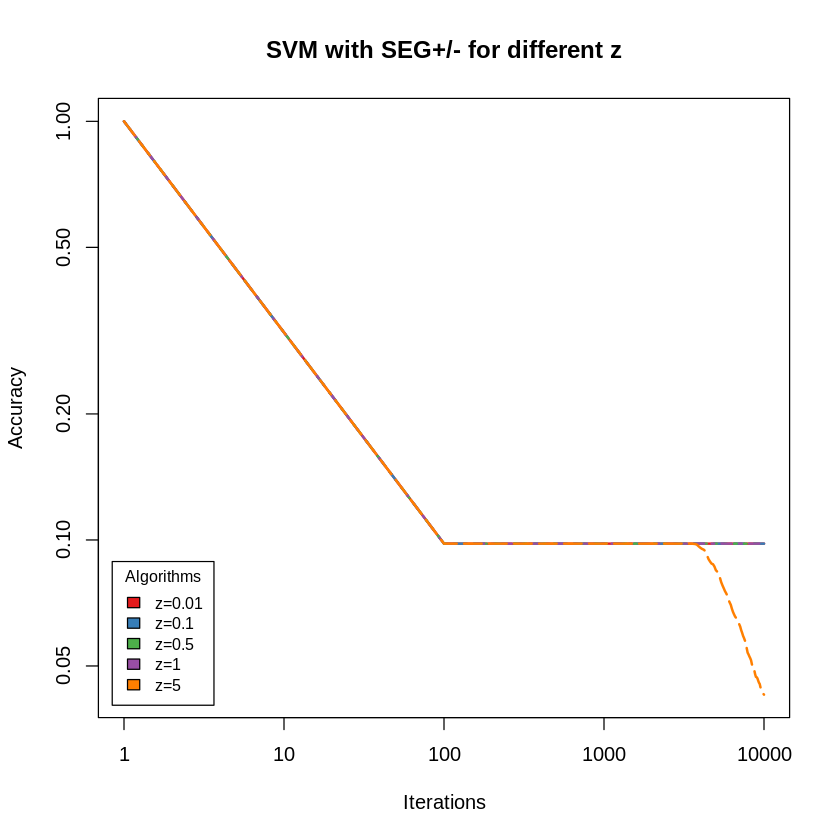

In [29]:
matplot(paramSEGpm6[,1],cbind(1-rateSEGpm1, 1-rateSEGpm2, 1-rateSEGpm3, 1-rateSEGpm4, 1-rateSEGpm5) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SEG+/- for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=0.01","z=0.1","z=0.5","z=1","z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

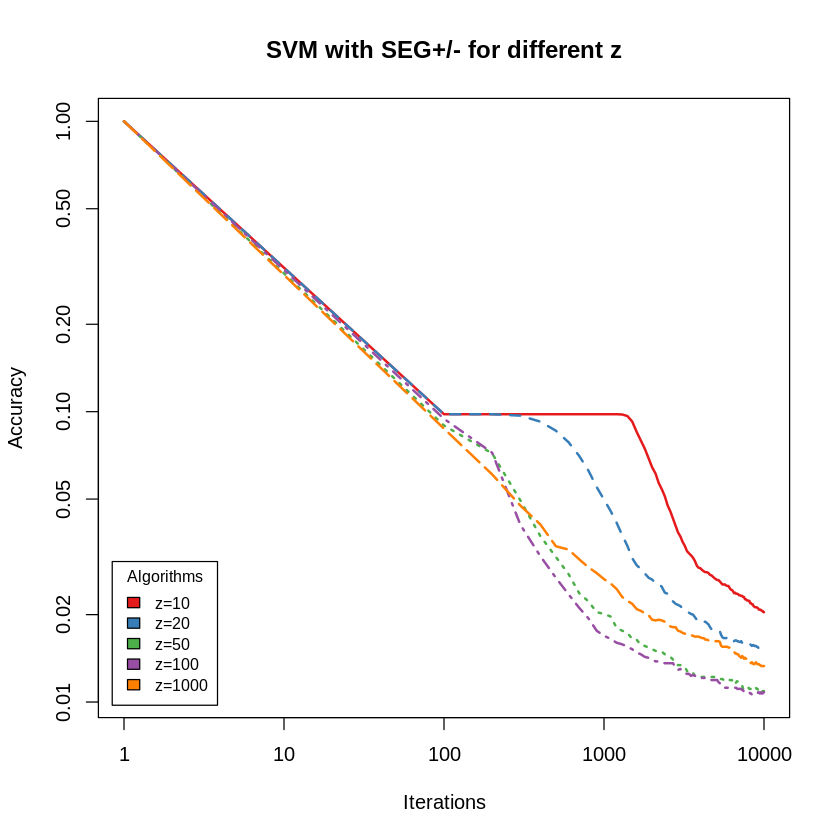

In [30]:
matplot(paramSEGpm6[,1],cbind(1-rateSEGpm6, 1-rateSEGpm7, 1-rateSEGpm8, 1-rateSEGpm9, 1-rateSEGpm10) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SEG+/- for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=10","z=20","z=50","z=100","z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

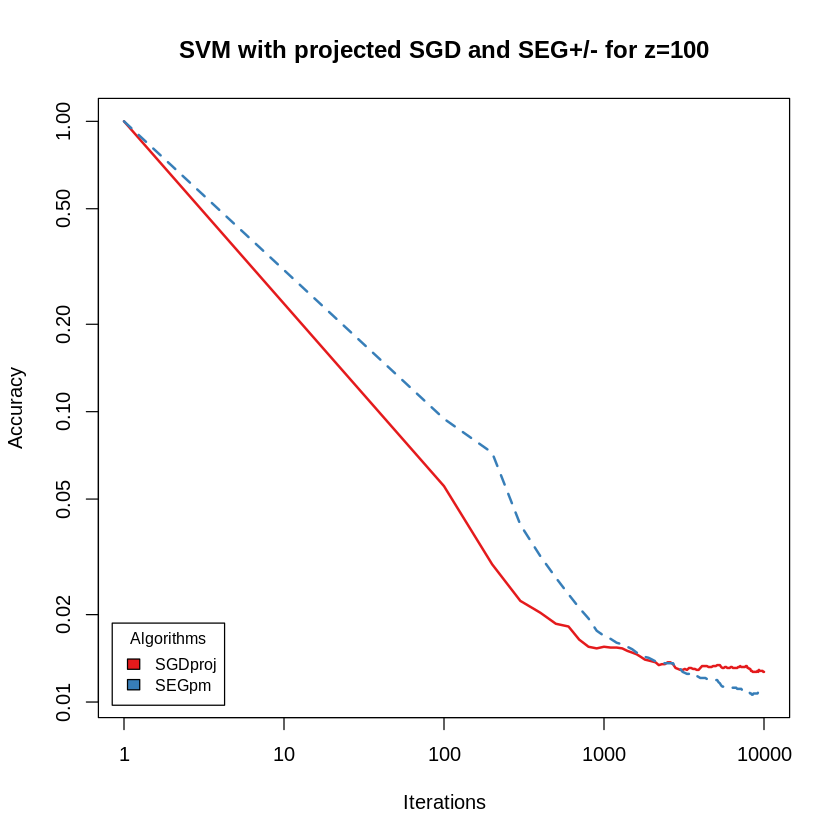

In [31]:
matplot(paramSGDproj2[,1],cbind(1-rateSGDproj2, 1-rateSEGpm9) ,type="l",col=brewer.pal(2,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SGD and SEG+/- for z=100",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("SGDproj","SEGpm"), fill=brewer.pal(2,"Set1"), cex=0.8)

### AdaGrad

In [32]:
Adaproj <- function(a, b, init, iters = length(b), cost,  instgrad, lambda,z=Inf ) {
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  d <- dim(a)[2]

  param <- data.frame(matrix(nrow = 101, ncol = length(init) + 1))
  colnames(param) <- c(colnames(a), "Loss")
  s <- rep(.0001,d)
  x <- c(init)
  m <- x
  param[1, ] <- c(m, cost(m, a, b,lambda))
  j<-2
  
  for (i in 1:iters) { 
    s <- s + instgrad(x, a[i,], b[i], lambda)^2
    y <- x -  1/sqrt(s) * instgrad(x, a[i,], b[i], lambda)  
    x <- pib1w(y,sqrt(s),z)
    m <- ((i-1)*m+x)/i
    if (i%% (iters/100) == 0)
    {
      param[j, ] <- c(m,cost(m, a, b,lambda))
      j<-j+1
    }
  }
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

In [33]:
start_time <- Sys.time()
set.seed(100)
paramAdaproj1 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=0.01) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj2 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=0.1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj3 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=0.5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj4 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj5 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj6 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=10) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj7 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=20) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj8 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=50) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj9 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramAdaproj10 <- Adaproj(a = as.matrix(train[,-1]),
                    b = train[,1],
                    init = rep(0, dim(train[-1])[2]),
                    iters = 10000,  # =1000 Play with the number of iterations
                    cost = hingereg,
                    instgrad = instgradreg,
                    lambda = 0,
                    z=1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
end_time - start_time

paramSGDproj3 <- SGDproj(a = as.matrix(train[,-1]),
                        b = train[,1],
                        init = rep(0, dim(train[-1])[2]),
                        iters = 10000,  # =1000 Play with the number of iterations
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 1e-1,
                        z = 1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 4.600334 secs

Time difference of 5.595493 secs

Time difference of 5.357734 secs

Time difference of 5.141316 secs

Time difference of 3.654238 secs

Time difference of 4.268989 secs

Time difference of 3.189551 secs

Time difference of 2.83654 secs

Time difference of 2.538259 secs

Time difference of 2.463121 secs

Time difference of 4.508294 secs


In [34]:
rateAdaproj1 <- rate(paramAdaproj1,test)
rateAdaproj2<- rate(paramAdaproj2,test)
rateAdaproj3 <- rate(paramAdaproj3,test)
rateAdaproj4 <- rate(paramAdaproj4,test)
rateAdaproj5 <- rate(paramAdaproj5,test)
rateAdaproj6 <- rate(paramAdaproj6,test)
rateAdaproj7 <- rate(paramAdaproj7,test)
rateAdaproj8 <- rate(paramAdaproj8,test)
rateAdaproj9 <- rate(paramAdaproj9,test)
rateAdaproj10 <- rate(paramAdaproj10,test)

rateSGDproj3 <- rate(paramSGDproj3, test)

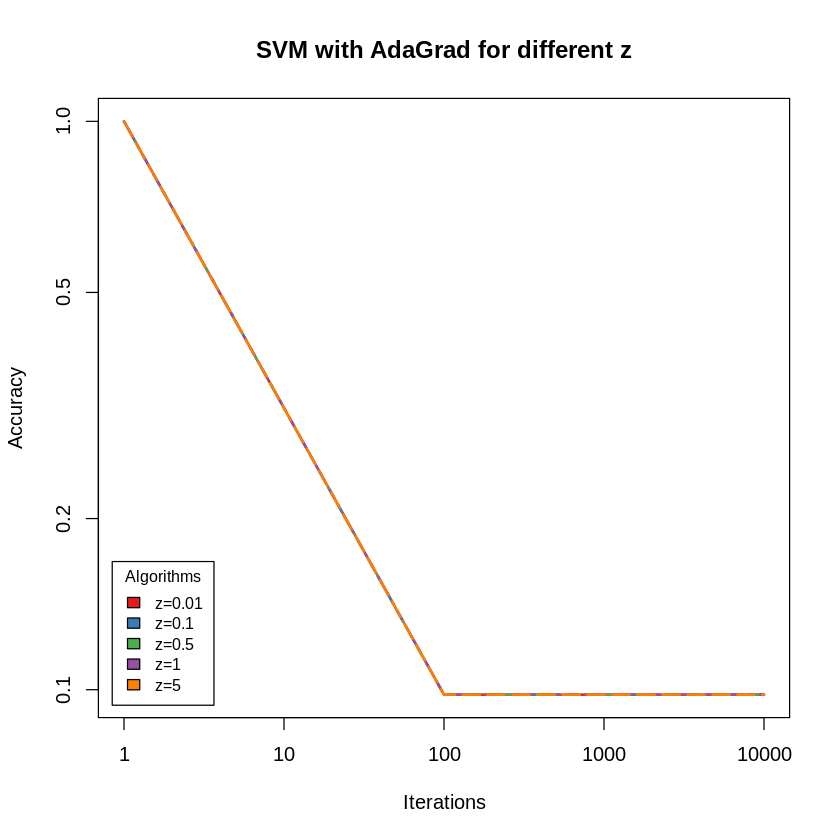

In [35]:
matplot(paramAdaproj1[,1],cbind(1-rateAdaproj1, 1-rateAdaproj2, 1-rateAdaproj3, 1-rateAdaproj4, 1-rateAdaproj5) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with AdaGrad for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=0.01","z=0.1","z=0.5","z=1","z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

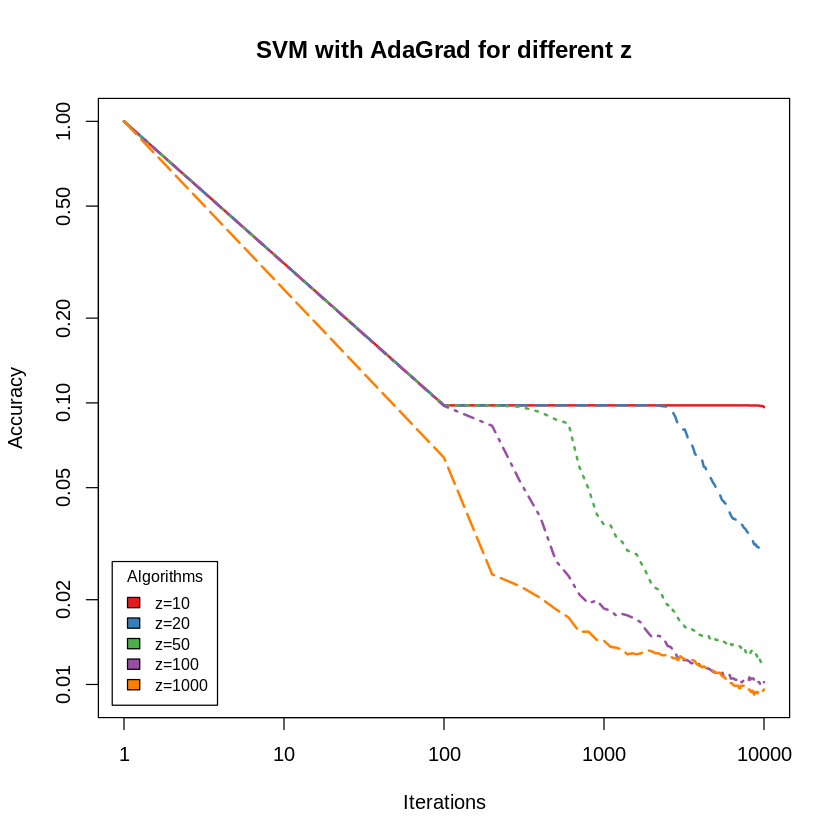

In [36]:
matplot(paramAdaproj6[,1],cbind(1-rateAdaproj6, 1-rateAdaproj7, 1-rateAdaproj8, 1-rateAdaproj9, 1-rateAdaproj10) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with AdaGrad for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=10","z=20","z=50","z=100","z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

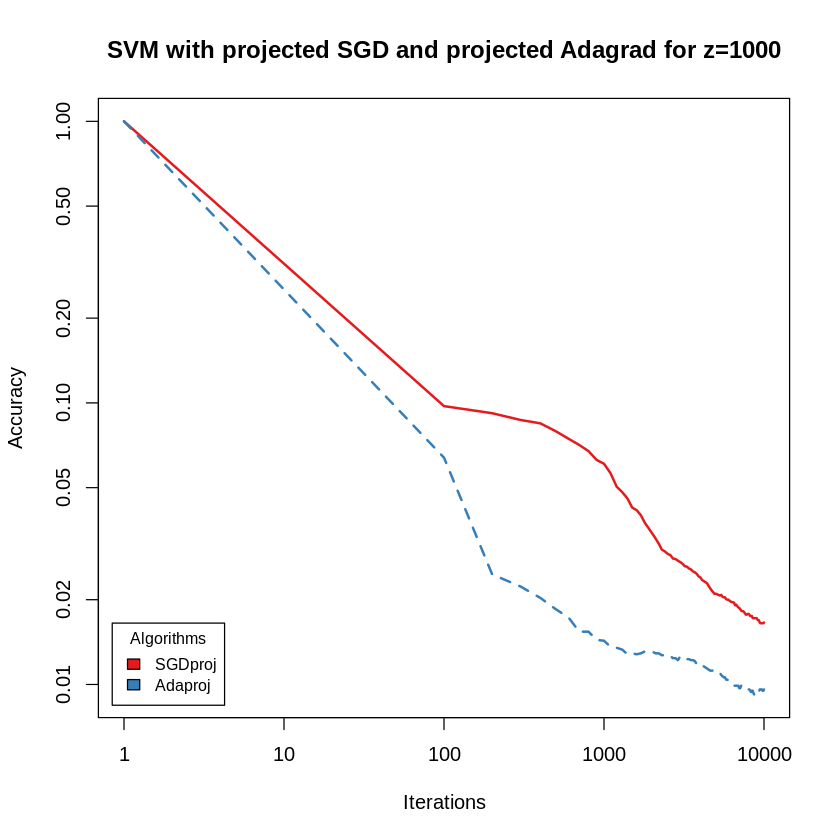

In [37]:
matplot(paramSGDproj1[,1],cbind(1-rateSGDproj3, 1-rateAdaproj10) ,type="l",col=brewer.pal(2,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected SGD and projected Adagrad for z=1000",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("SGDproj","Adaproj"), fill=brewer.pal(2,"Set1"), cex=0.8)

## 5 Online Newton Step

In [38]:
ONS <- function(a, b, init, iters = length(b), cost,  instgrad, lambda,gamm,z) {
  
  ind<-sample(1:length(b),iters,replace=TRUE)
  a <- a[ind,]
  b <- b[ind]
  d <- length(init)
  param <- data.frame(matrix(nrow = 101, ncol = d + 1))
  colnames(param) <- c(colnames(a), "Loss")
  x <- c(init)
  m <- x
  A <- diag(rep(1/gamm^2,d))
  Ainv <- diag(rep(gamm^2,d))
  param[1, ] <- c(m, cost( m, a, b,lambda))
  j <- 2
  
  for (i in 1:iters) { 
    instg <-  c(instgrad(x, a[i,], b[i], lambda))
    A <- A + instg%*%t(instg) 
    Ainstg <- Ainv%*%instg
    Ainv <- Ainv - c(1/(1+t(instg)%*%Ainstg)) * Ainstg%*%t(Ainstg)
    y <- x -  1/gamm * Ainv %*% instg
    x <- pib1w(y,diag(A),z)
    m <- ((i-1)*m + x)/i
    if (i%% (iters/100) == 0)
    {
      param[j, ] <- c(m,cost(m, a, b,lambda))
      j<-j+1
    }
  }
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

In [39]:
# changing lambda
start_time <- Sys.time()
set.seed(100)
paramONSlambd1 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 1/8,
                      z=100)
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramONSlambd2 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.1,
                      gamm = 1/8,
                      z=100)
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramONSlambd3 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 1/3,
                      gamm = 1/8,
                      z=100)
end_time <- Sys.time()
end_time - start_time

Time difference of 47.93419 secs

Time difference of 38.64942 secs

Time difference of 48.74277 secs

In [40]:
rateONSlambd1 <- rate(paramONSlambd1,test)
rateONSlambd2 <- rate(paramONSlambd2,test)
rateONSlambd3 <- rate(paramONSlambd3,test)

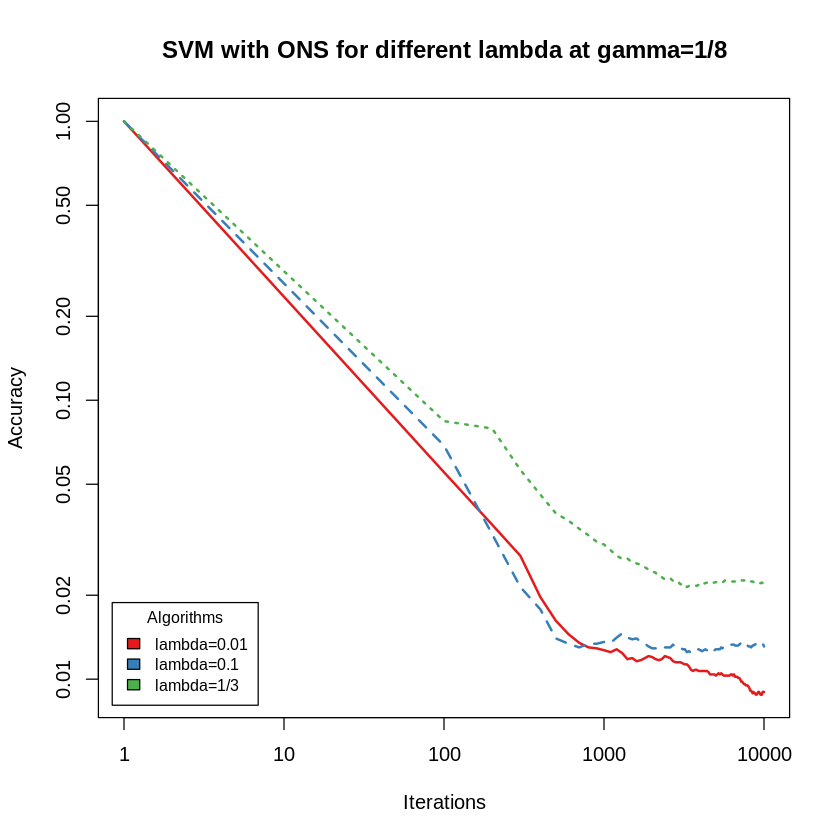

In [41]:
matplot(paramONSlambd1[,1] ,cbind(1-rateONSlambd1, 1-rateONSlambd2, 1-rateONSlambd3) ,type="l",col=brewer.pal(3,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with ONS for different lambda at gamma=1/8",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("lambda=0.01", "lambda=0.1", "lambda=1/3"), fill=brewer.pal(3,"Set1"), cex=0.8)

In [42]:
# changing gamma
start_time <- Sys.time()
set.seed(100)
paramONSgamma1 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 0.01,
                      z=100)
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramONSgamma2 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 1/8,
                      z=100)
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramONSgamma3 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 1/2,
                      z=100)
end_time <- Sys.time()
end_time - start_time

Time difference of 51.4724 secs

Time difference of 49.27839 secs

Time difference of 43.65945 secs

In [43]:
rateONSgamma1 <- rate(paramONSgamma1,test)
rateONSgamma2 <- rate(paramONSgamma2,test)
rateONSgamma3 <- rate(paramONSgamma3,test)

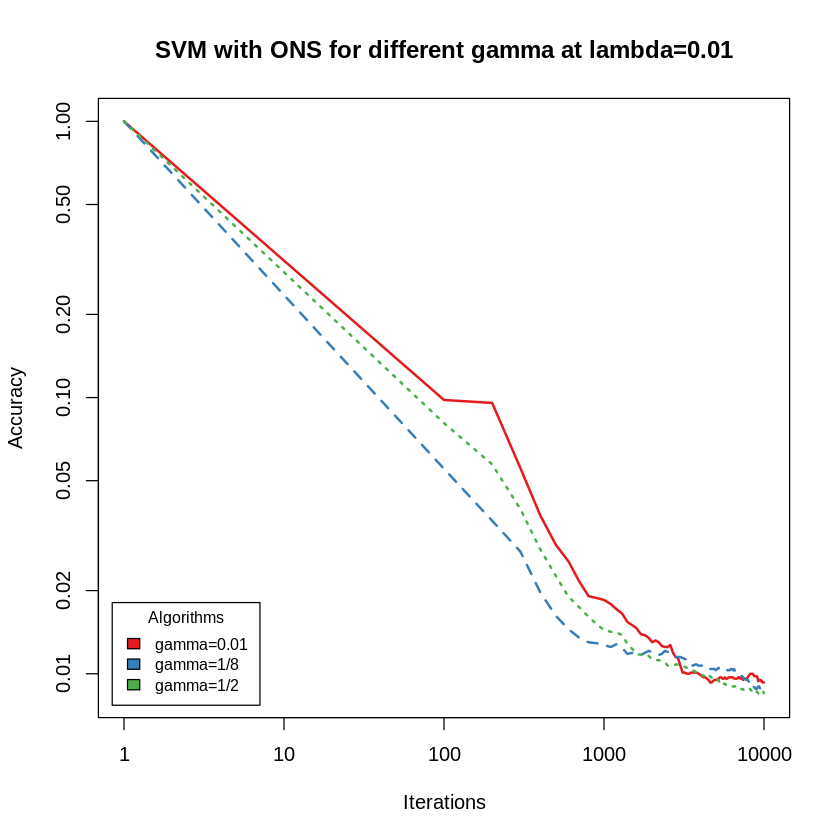

In [44]:
matplot(cbind(paramONSgamma1[,1], paramONSgamma2[,1], paramONSgamma3[,1]),cbind(1-rateONSgamma1, 1-rateONSgamma2, 1-rateONSgamma3) ,type="l",col=brewer.pal(3,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with ONS for different gamma at lambda=0.01",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("gamma=0.01", "gamma=1/8", "gamma=1/2"), fill=brewer.pal(3,"Set1"), cex=0.8)

In [45]:
# changing z
start_time <- Sys.time()
set.seed(100)
paramONSz1 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 1/2,
                      z=10)
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramONSz2 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 1/2,
                      z=100)
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
set.seed(100)
paramONSz3 <- ONS(a = as.matrix(train[,-1]),
                      b = train[,1],
                      iters = 10000,  # =1000 Play with the number of iterations
                      init = rep(0, dim(train[-1])[2]),
                      cost = hingereg,
                      instgrad = instgradreg,
                      lambda = 0.01,
                      gamm = 1/2,
                      z=1000)
end_time <- Sys.time()
end_time - start_time

Time difference of 57.8551 secs

Time difference of 49.37783 secs

Time difference of 44.59132 secs

In [46]:
rateONSz1 <- rate(paramONSz1,test)
rateONSz2 <- rate(paramONSz2,test)
rateONSz3 <- rate(paramONSz3,test)

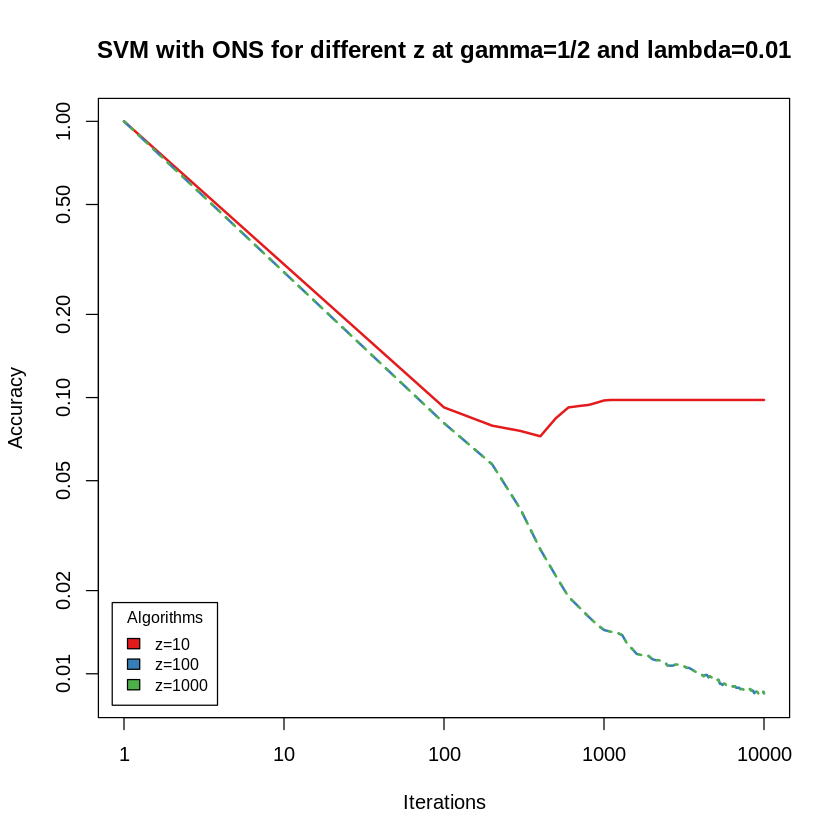

In [47]:
matplot(paramONSz1[,1],cbind(1-rateONSz1, 1-rateONSz2, 1-rateONSz3) ,type="l",col=brewer.pal(3,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with ONS for different z at gamma=1/2 and lambda=0.01",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=10", "z=100", "z=1000"), fill=brewer.pal(3,"Set1"), cex=0.8)

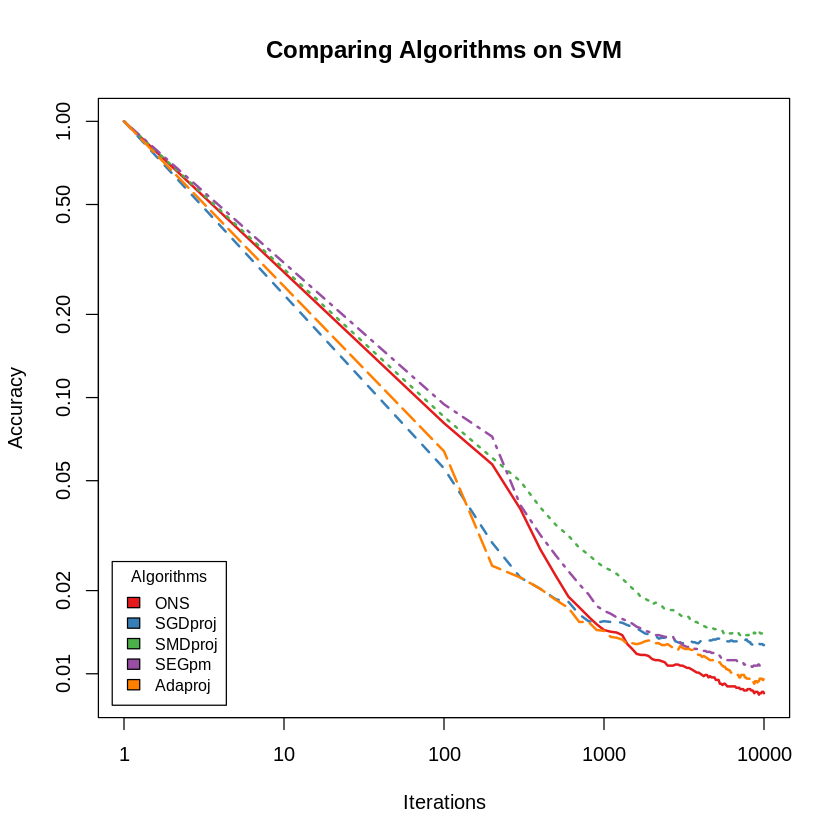

In [48]:
# comparing algorithms
matplot(paramONSz2[,1],cbind(1-rateONSz2, 1-rateSGDproj9, 1-rateSMDproj9, 1-rateSEGpm9, 1-rateAdaproj10) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "Comparing Algorithms on SVM",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("ONS", "SGDproj", "SMDproj", "SEGpm", "Adaproj"), fill=brewer.pal(5,"Set1"), cex=0.8)


## 6 Explorations methods

In [49]:
SREGpm <- function(a, b, iters = length(b), cost,  instgrad, lambda,z) {
  
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  d <- ncol(a)
  
  param <- data.frame(matrix(nrow = 101, ncol = d + 1))
  colnames(param) <- c(colnames(a), "Loss")
  w <- rep(1,2*d)
  w <- w/sum(w)
  x <- z*c(w[1:d]-w[d+1:d])
  m <- x
  param[1, ] <- c(m, cost(x, a, b,lambda)) 
  k <- 2

  for (i in 1:iters) {
    eta <- min(d/sqrt(i),1)
    j <- sample(1:d,1,replace=TRUE)
    instgj <- instgrad(x[j], a[i,j], b[i], lambda)
    w[c(j,j+d)]<-  exp( eta * c(-instgj,instgj ))*w[c(j,j+d)] 
    w <- w/sum(w)
    x <- z*c(w[1:d]-w[d+1:d])
    m <- ((i-1)*m+x)/i
    if (i%% (iters/100) == 0)
    {
      param[k, ] <- c(m,cost(m, a, b,lambda))
      k<-k+1
    }
  }
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

SBEGpm <- function(a, b, iters = length(b), cost,  instgrad, lambda,z) {
  
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  d <- ncol(a)
  
  param <- data.frame(matrix(nrow = 101, ncol = d + 1))
  colnames(param) <- c(colnames(a), "Loss")
  w <- rep(1,2*d)
  w <- w/sum(w)
  x <- z*c(w[1:d]-w[d+1:d])
  m <- x
  param[1, ] <- c(m, cost(x, a, b,lambda)) 
  k <- 2
  
  for (i in 1:iters) {
    eta <- sqrt(1/(i*2*d))
    A <- sample(1:(2*d),1,prob = w)
    j <- A*(A<=d)+(A-d)*(A>d)
    s <- 1-2*(A>d)
    instgj <- instgrad(x[j], a[i,j], b[i], lambda)
    w[A]<-  exp(- s* eta * instgj/w[A])*w[A] 
    w <- (1-eta)*w/sum(w)+eta/(2*d)
    x <- z*c(w[1:d]-w[d+1:d])
    m <- ((i-1)*m+x)/i
    if (i%% (iters/100) == 0)
    {
      param[k, ] <- c(m,cost(m, a, b,lambda))
      k<-k+1
    }
  }
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

In [50]:
start_time <- Sys.time()
set.seed(100)
paramSBEGpm1 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=0.01) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm2 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=0.1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm3 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=0.5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm4 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm5 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm6 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=10) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm7 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=20) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm8 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=50) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm9 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)
paramSBEGpm10 <- SBEGpm(a = as.matrix(train[,-1]),
                         b = train[,1],
                         cost = hingereg,
                         instgrad = instgradreg,
                         lambda = 0,
                         z=1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 21.35187 secs
Time difference of 22.14937 secs
Time difference of 17.73761 secs
Time difference of 16.47608 secs
Time difference of 15.56764 secs
Time difference of 15.67651 secs
Time difference of 21.52308 secs
Time difference of 18.90877 secs
Time difference of 17.71794 secs
Time difference of 16.4339 secs


In [51]:
rateSBEGpm1 <- rate(paramSBEGpm1,test)
rateSBEGpm2 <- rate(paramSBEGpm2,test)
rateSBEGpm3 <- rate(paramSBEGpm3,test)
rateSBEGpm4 <- rate(paramSBEGpm4,test)
rateSBEGpm5 <- rate(paramSBEGpm5,test)
rateSBEGpm6 <- rate(paramSBEGpm6,test)
rateSBEGpm7 <- rate(paramSBEGpm7,test)
rateSBEGpm8 <- rate(paramSBEGpm8,test)
rateSBEGpm9 <- rate(paramSBEGpm9,test)
rateSBEGpm10 <- rate(paramSBEGpm10,test)

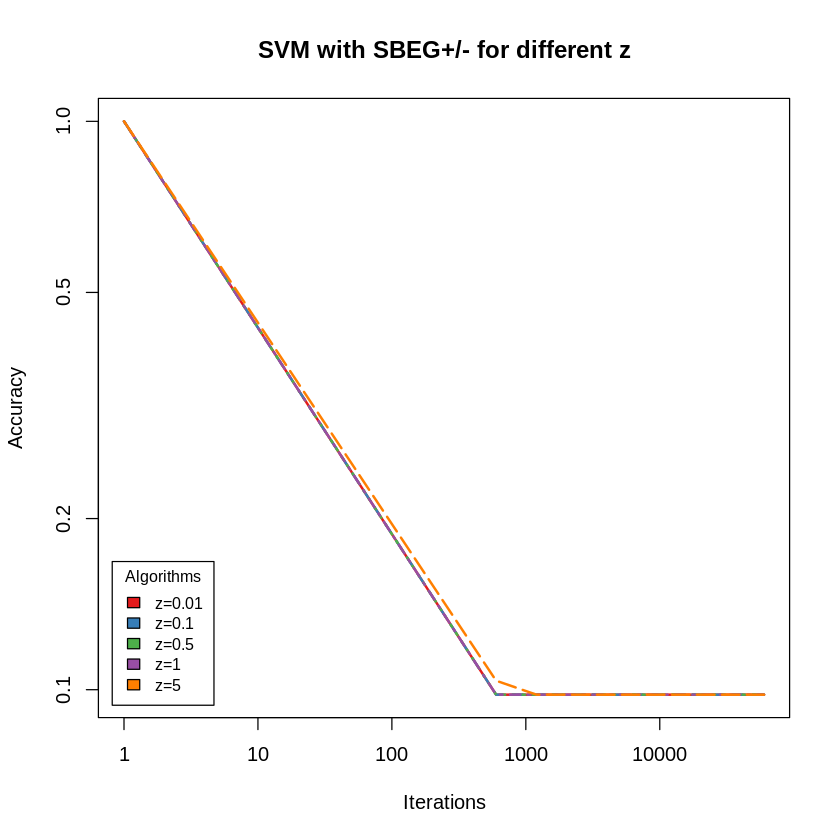

In [52]:
matplot(paramSBEGpm1[,1],cbind(1-rateSBEGpm1, 1-rateSBEGpm2, 1-rateSBEGpm3, 1-rateSBEGpm4, 1-rateSBEGpm5) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SBEG+/- for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=0.01","z=0.1","z=0.5","z=1","z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

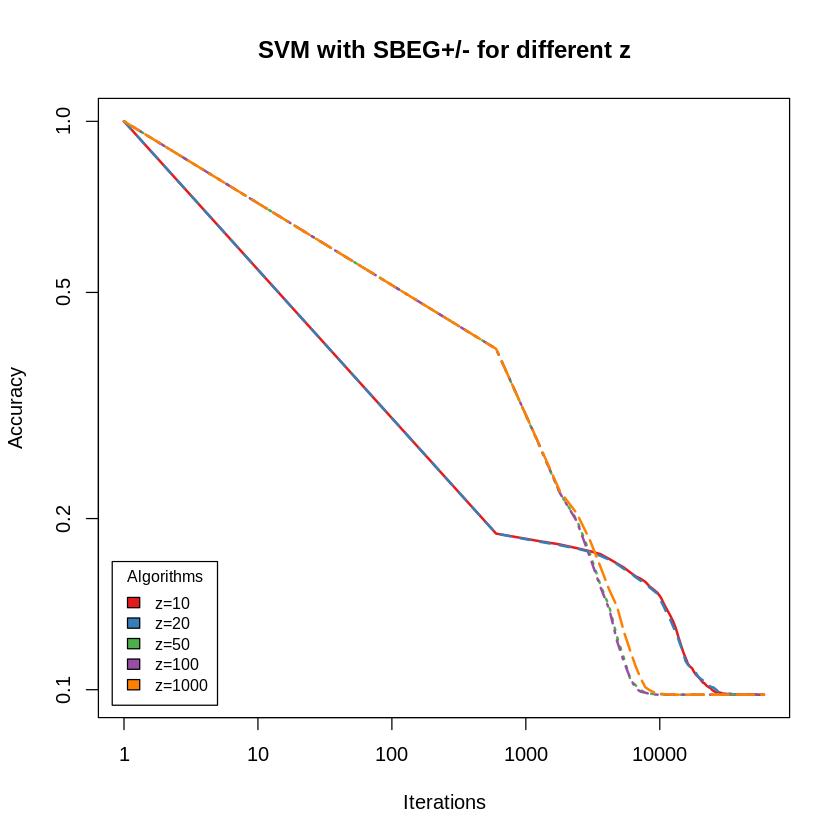

In [53]:
matplot(paramSBEGpm1[,1],cbind(1-rateSBEGpm6, 1-rateSBEGpm7, 1-rateSBEGpm8, 1-rateSBEGpm9, 1-rateSBEGpm10) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SBEG+/- for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=10","z=20","z=50","z=100","z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

In [54]:
start_time <- Sys.time()
set.seed(100)

paramSREGpm1 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 0.01) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm2 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 0.1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm3 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 0.5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm4 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 1) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm5 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 5) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm6 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 10) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm7 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 20) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm8 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 50) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

start_time <- Sys.time()
set.seed(100)

paramSREGpm9 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 100) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)


start_time <- Sys.time()
set.seed(100)

paramSREGpm10 <- SREGpm(a = as.matrix(train[,-1]),
                        b = train[,1],
                        cost = hingereg,
                        instgrad = instgradreg,
                        lambda = 0,
                        z = 1000) # Play with the diameter of the l1 ball
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 13.72381 secs
Time difference of 13.47437 secs
Time difference of 12.12552 secs
Time difference of 11.21533 secs
Time difference of 12.69426 secs
Time difference of 17.43602 secs
Time difference of 17.55743 secs
Time difference of 14.12107 secs
Time difference of 12.92646 secs
Time difference of 11.75268 secs


In [55]:
rateSREGpm1 <- rate(paramSREGpm1,test)
rateSREGpm2 <- rate(paramSREGpm2,test)
rateSREGpm3 <- rate(paramSREGpm3,test)
rateSREGpm4 <- rate(paramSREGpm4,test)
rateSREGpm5 <- rate(paramSREGpm5,test)
rateSREGpm6 <- rate(paramSREGpm6,test)
rateSREGpm7 <- rate(paramSREGpm7,test)
rateSREGpm8 <- rate(paramSREGpm8,test)
rateSREGpm9 <- rate(paramSREGpm9,test)
rateSREGpm10 <- rate(paramSREGpm10,test)

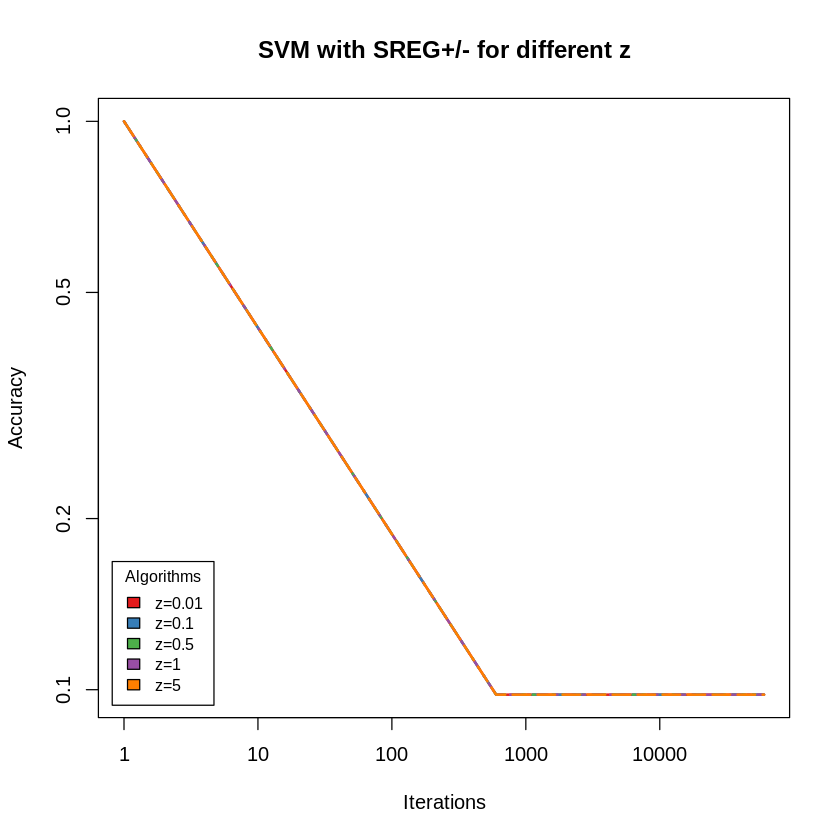

In [56]:
matplot(paramSREGpm1[,1],cbind(1-rateSREGpm1, 1-rateSREGpm2, 1-rateSREGpm3, 1-rateSREGpm4, 1-rateSREGpm5) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SREG+/- for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=0.01","z=0.1","z=0.5","z=1","z=5"), fill=brewer.pal(5,"Set1"), cex=0.8)

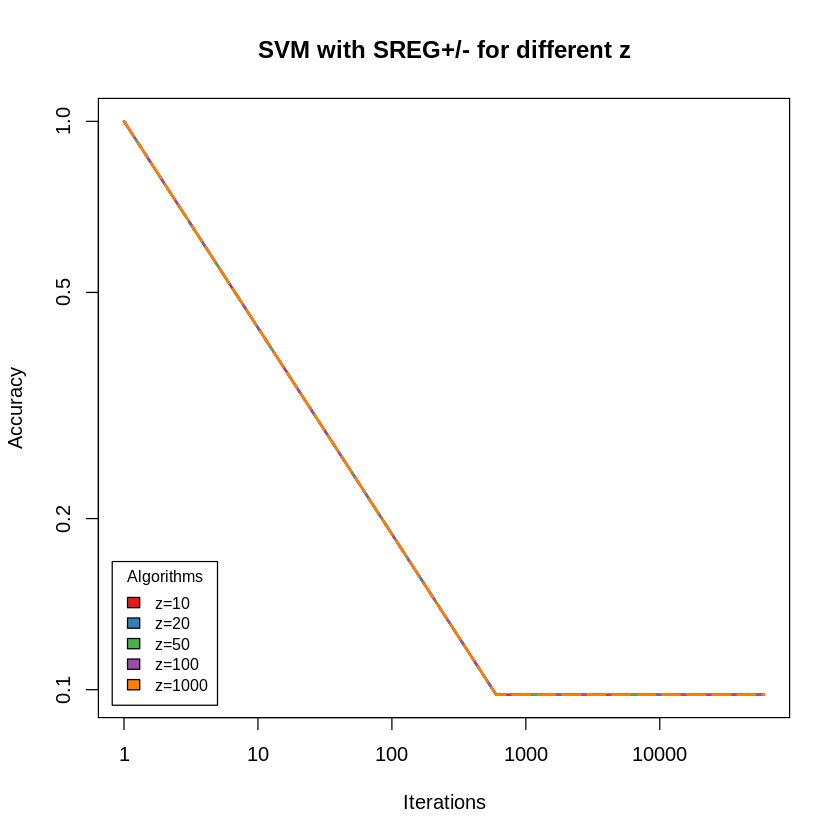

In [57]:
matplot(paramSREGpm1[,1],cbind(1-rateSREGpm6, 1-rateSREGpm7, 1-rateSREGpm8, 1-rateSREGpm9, 1-rateSREGpm10) ,type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SREG+/- for different z",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("z=10","z=20","z=50","z=100","z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

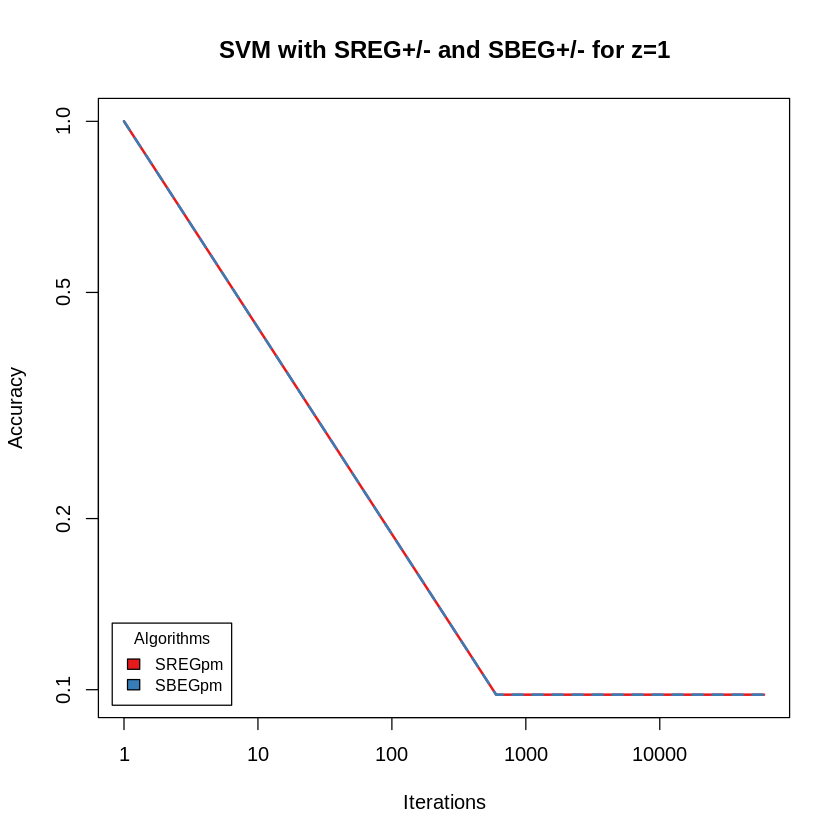

In [58]:
matplot(paramSREGpm1[,1],cbind(1-rateSREGpm4, 1-rateSBEGpm4) ,type="l",col=brewer.pal(2,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with SREG+/- and SBEG+/- for z=1",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("SREGpm","SBEGpm"), fill=brewer.pal(2,"Set1"), cex=0.8)

In [59]:
regretBoundSB <- function(z, T) {
    return(3*z*sqrt(2*784*log(2*784))/sqrt(T))
}

In [60]:
regretBoundSR <- function(z, T) {
    return(784*z*sqrt(2*log(784))/sqrt(T))
}

In [61]:
rateSR <- rep(1, 101)
for (t in 1:101) {
    rateSR[t] <- regretBoundSR(1, t*1000)
}
rateSR <- rateSR/max(rateSR)

In [62]:
rateSB <- rep(1, 101)
for (t in 1:101) {
    rateSB[t] <- regretBoundSB(100, t*1000)
}
rateSB <- rateSB/max(rateSB)

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

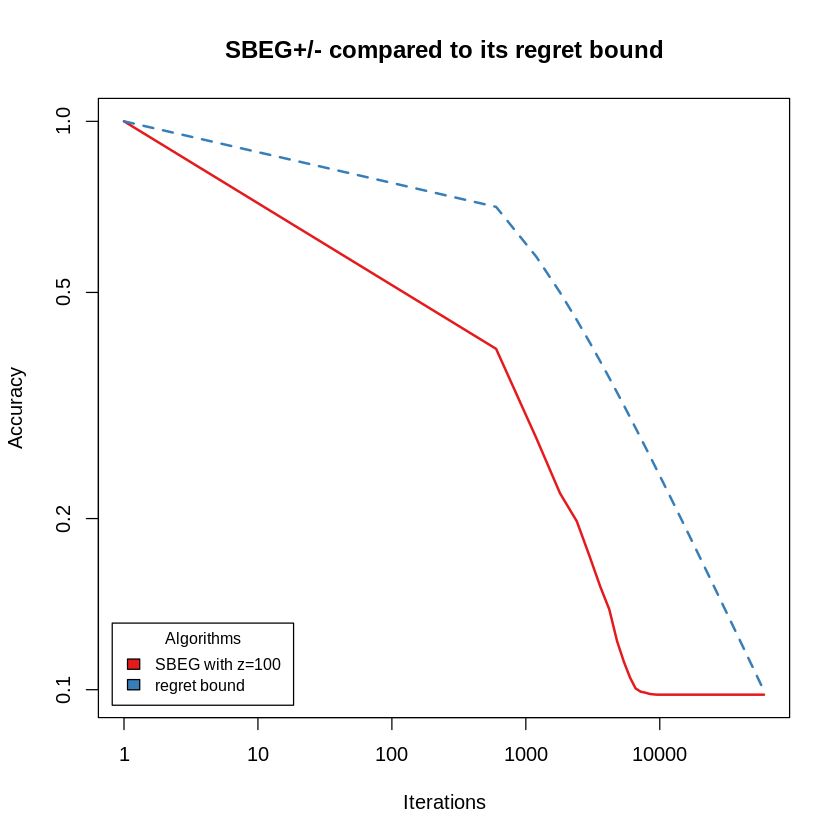

In [63]:
matplot(paramSBEGpm9[,1],cbind(1-rateSBEGpm9, rateSB) ,type="l",col=brewer.pal(2,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SBEG+/- compared to its regret bound",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("SBEG with z=100","regret bound"), fill=brewer.pal(2,"Set1"), cex=0.8)

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

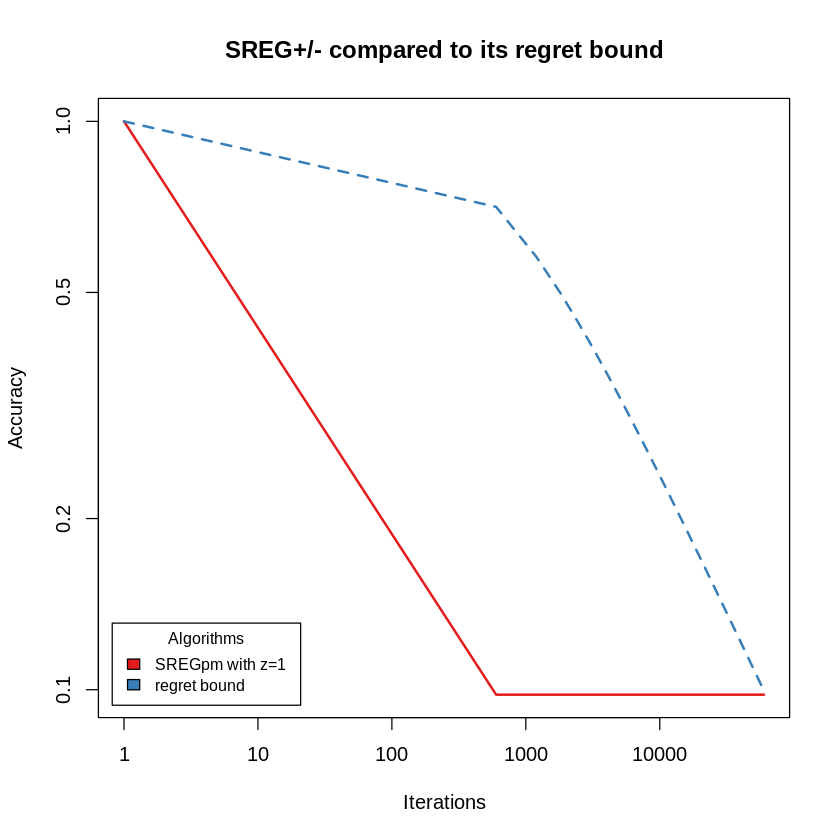

In [64]:
library(RColorBrewer)

matplot(paramSREGpm4[,1],cbind(1-rateSREGpm4, rateSR) ,type="l",col=brewer.pal(2,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SREG+/- compared to its regret bound",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("SREGpm with z=1","regret bound"), fill=brewer.pal(2,"Set1"), cex=0.8)

## 7 Follow The Moving Leader

Follow the moving leader - see Zheng, Kwok: http://proceedings.mlr.press/v70/zheng17a/zheng17a.pdf

In [65]:
# FTML algorithm

FTML <- function(a, b, init, iters = length(b), cost,  instgrad, lambda,z=Inf, b1) {
  ind<-sample(1:length(b),iters,replace=TRUE)
  a<-a[ind,]
  b<-b[ind]
  d <- dim(a)[2]
  
  param <- data.frame(matrix(nrow = 101, ncol = length(init) + 1))
  colnames(param) <- c(colnames(a), "Loss")
  del <- rep(0,d)
  v <- rep(0,d)
  y <- rep(0,d)
  x <- c(init)
  eps <- rep(.00000001,d)
  #m <- x
  param[1, ] <- c(x, cost(x, a, b,lambda))
  j<-2
  
  for (i in 1:iters) { 
    eta <- sqrt(1/i)  # play around with different decreasing eta
    g <- instgrad(x, a[i,], b[i], lambda)
    v <- 0.999*v + (1-0.999)*g^2
    del_old <- del
    del <- (1-b1^i)/eta * (sqrt(v/(1-0.999^i)) + eps) # what to choose for epsilon_t?
    sigma <- del - b1*del_old
    y <- b1*y + (1-b1)*g - sigma*x
    x <- pib1w(-y/del, del/(1-b1^i), z)
    if (i%% (iters/100) == 0)
    {
      param[j, ] <- c(x,cost(x, a, b,lambda))
      j<-j+1
    }
  }
  
  param <- cbind(Iteration = c(1,1:100*(iters/100)), param)
  
  return(param)
  
}

In [66]:
# different values of beta_1

set.seed(100)
start_time <- Sys.time()
paramFTML1 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          b1 = 0.3) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramFTML2 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          b1 = 0.5) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramFTML3 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          b1 = 0.6) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramFTML4 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          b1 = 0.7) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

start_time <- Sys.time()
paramFTML5 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          b1 = 0.8) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

Time difference of 22.20503 secs

Time difference of 26.18926 secs

Time difference of 25.57449 secs

Time difference of 26.63683 secs

Time difference of 23.54599 secs

In [67]:
rateFTML1 <- rate(paramFTML1,test)
rateFTML2 <- rate(paramFTML2,test)
rateFTML3 <- rate(paramFTML3,test)
rateFTML4 <- rate(paramFTML4,test)
rateFTML5 <- rate(paramFTML5,test)

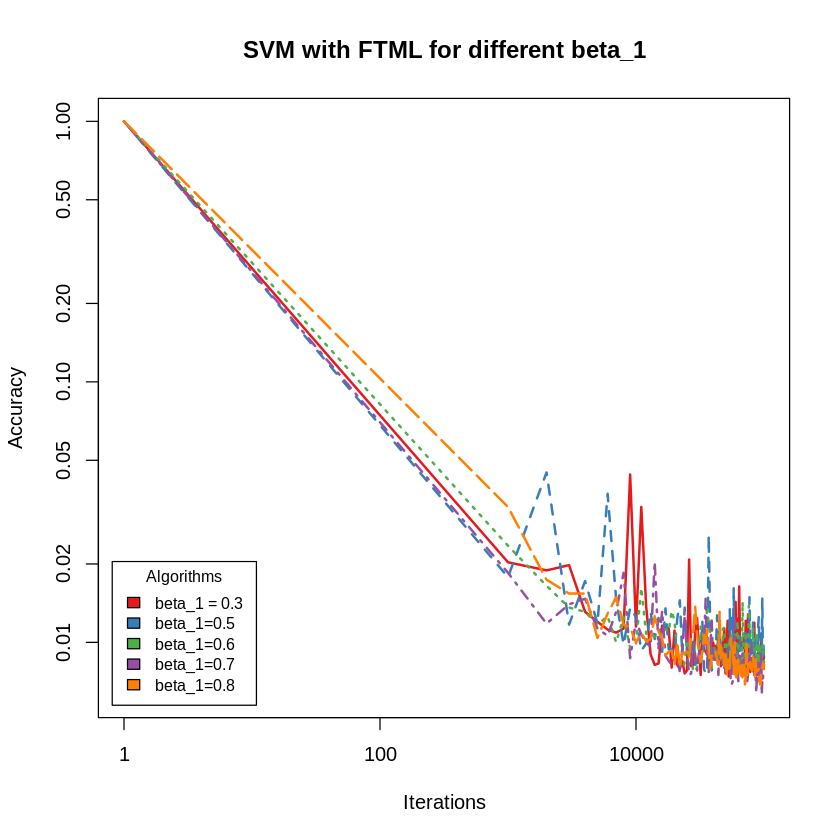

In [68]:
library(RColorBrewer)

matplot(paramFTML1[,1],cbind(1-rateFTML1, 1-rateFTML2, 1-rateFTML3, 1-rateFTML4, 1-rateFTML5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with FTML for different beta_1",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("beta_1 = 0.3", "beta_1=0.5", "beta_1=0.6", "beta_1=0.7", "beta_1=0.8"), fill=brewer.pal(5,"Set1"), cex=0.8)

In [69]:
# different values of z

set.seed(100)
start_time <- Sys.time()
paramFTMLproj1 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          z = 1,
                          b1 = 0.7) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

set.seed(100)
start_time <- Sys.time()
paramFTMLproj2 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          z = 10,
                          b1 = 0.7) # Play with beta 1
end_time <- Sys.time()
end_time - start_time


set.seed(100)
start_time <- Sys.time()
paramFTMLproj3 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          z = 30,
                          b1 = 0.7) # Play with beta 1
end_time <- Sys.time()
end_time - start_time


set.seed(100)
start_time <- Sys.time()
paramFTMLproj4 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          z = 100,
                          b1 = 0.7) # Play with beta 1
end_time <- Sys.time()
end_time - start_time

set.seed(100)
start_time <- Sys.time()
paramFTMLproj5 <- FTML(a = as.matrix(train[,-1]),
                          b = train[,1],
                          init = rep(0, dim(train[-1])[2]),
                          iters = 100000,  # =1000 Play with the number of iterations
                          cost = hingereg,
                          instgrad = instgradreg,
                          lambda = 0,
                          z = 1000,
                          b1 = 0.7) # Play with beta 1
end_time <- Sys.time()
end_time - start_time


Time difference of 42.94648 secs

Time difference of 38.03781 secs

Time difference of 29.83047 secs

Time difference of 32.48176 secs

Time difference of 23.49854 secs

In [70]:
rateFTMLproj1 <- rate(paramFTMLproj1,test)
rateFTMLproj2 <- rate(paramFTMLproj2,test)
rateFTMLproj3 <- rate(paramFTMLproj3,test)
rateFTMLproj4 <- rate(paramFTMLproj4,test)
rateFTMLproj5 <- rate(paramFTMLproj5,test)

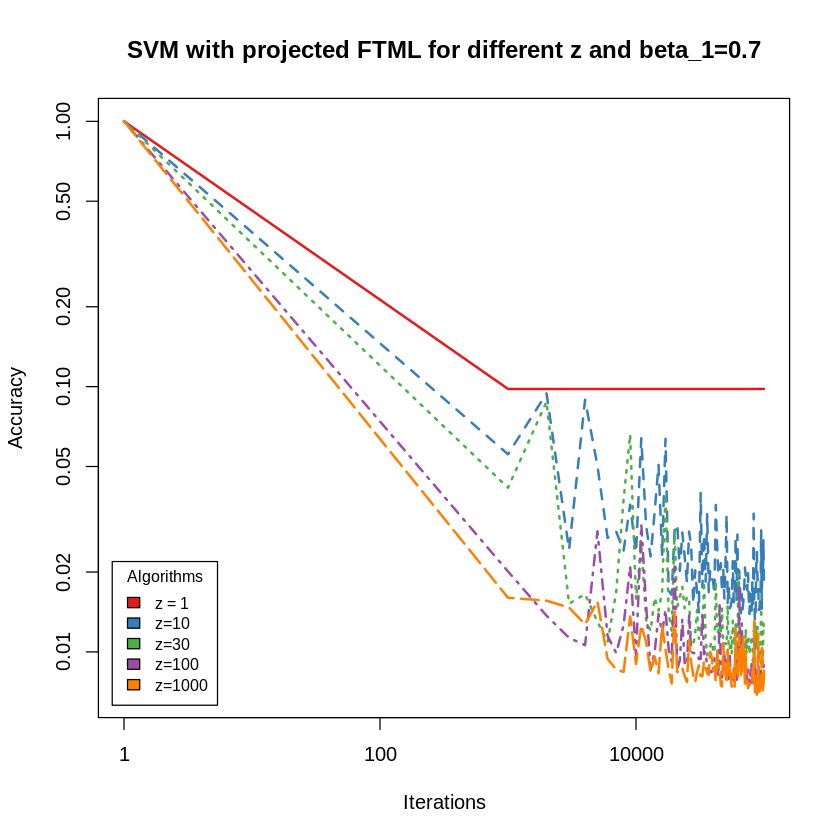

In [71]:
library(RColorBrewer)

matplot(paramFTMLproj1[,1],cbind(1-rateFTMLproj1, 1-rateFTMLproj2, 1-rateFTMLproj3, 1-rateFTMLproj4, 1-rateFTMLproj5),type="l",col=brewer.pal(5,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "SVM with projected FTML for different z and beta_1=0.7",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       c("z = 1", "z=10", "z=30", "z=100", "z=1000"), fill=brewer.pal(5,"Set1"), cex=0.8)

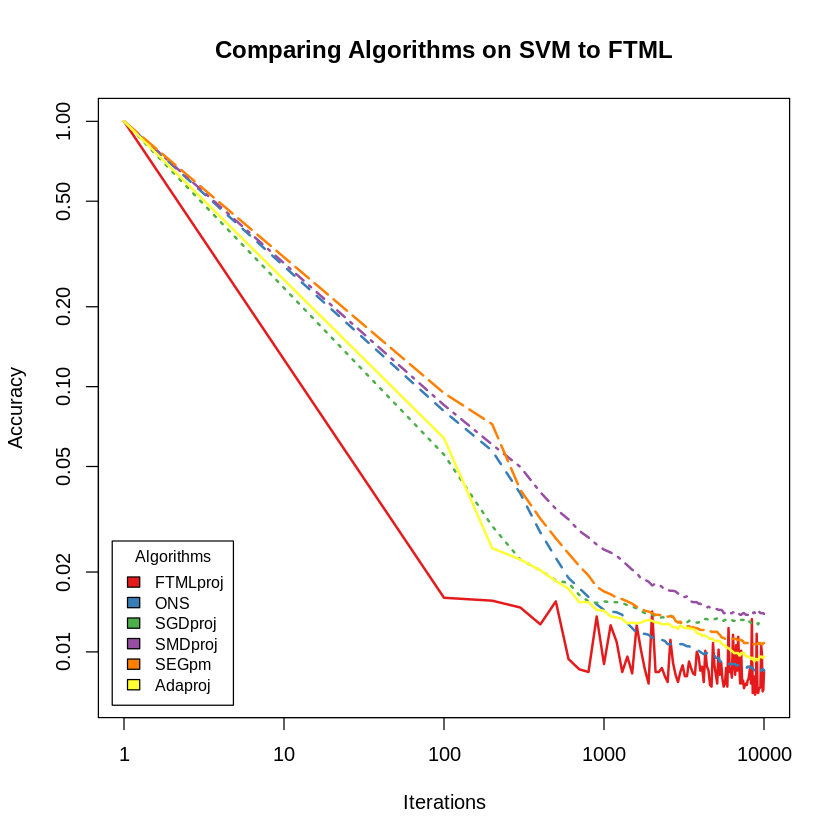

In [72]:
# comparison of all stochastic algorithms
# comparing algorithms
matplot(paramONSz2[,1],cbind(1-rateFTMLproj5,1-rateONSz2, 1-rateSGDproj9, 1-rateSMDproj9, 1-rateSEGpm9, 1-rateAdaproj10) ,type="l",col=brewer.pal(6,"Set1"),log="xy",xlab="Iterations",ylab="Accuracy",
        main = "Comparing Algorithms on SVM to FTML",lwd=2)
legend("bottomleft", inset=.02, title="Algorithms",
       cbind("FTMLproj","ONS", "SGDproj", "SMDproj", "SEGpm", "Adaproj"), fill=brewer.pal(6,"Set1"), cex=0.8)